# Participant report

This section aims at gathering the different information that could appear in an administration report. It will most likely be hierarchical with the most important information presented firt, followed by
the details.

1) Demographics of the participant and clinical data if available
2) Quality of the administration: missing data, compliance score
3) Prediction for the participant and interpretability resultd


If time allows, and if we think ut's necessary we can add (i) the distribution of the participant's face proportion of the screen and the actual participant point, (ii) Percentage of frame where the face where detected, etc. 

In [43]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


In [83]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:1F77B4-46.2:FFFFFF-100:FF7F0E
    (0.000, (0.122, 0.467, 0.706)),
    (0.462, (1.000, 1.000, 1.000)),
    (1.000, (1.000, 0.498, 0.055))))
csfont = {'fontname':'Times New Roman'}

def display_interaction_summary(matrix_shap):
    
    principal_effect_sum = np.diag(np.abs(matrix_shap)).sum()
    interaction_effect_sum = np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum()

    dict_shap = {}
    for i, feat in enumerate(exp.features_name):

        main_effect = np.abs(matrix_shap)[i,i]
        interaction_effect = np.abs(matrix_shap)[i].sum() - main_effect

        row_shap = deepcopy(np.abs(matrix_shap)[i])
        row_shap[i] = 0
        first_interaction = np.max(row_shap)
        first_interaction_name = exp.features_name[np.argmax(row_shap)]

        dict_shap[feat] = {'total': main_effect+interaction_effect, 'main': main_effect, 'interaction': interaction_effect, 'first_interaction': first_interaction, 'first_interaction_name': first_interaction_name}
    final_interactions_summary = pd.DataFrame(dict_shap).transpose().sort_values('total', ascending=False)
    final_interactions_summary = final_interactions_summary.append(pd.DataFrame([[100, principal_effect_sum, interaction_effect_sum, '', '']], index=['SUM'], columns = final_interactions_summary.columns))

    return final_interactions_summary


def plot_app_featurees_summary(exp, df_shap_summary, index_sample):
    from utils import select
    from matplotlib import rc
    plt.rcParams["font.serif"] = "Times New Roman"

    participant_id = exp.dataset.df.iloc[index_sample]['id']
    age = exp.dataset.df.iloc[index_sample]['age']
    sex = exp.dataset.df.iloc[index_sample]['sex']
    diagnosis = exp.dataset.df.iloc[index_sample]['diagnosis']
    

    n_plots = len(exp.features_name)
    fig, axes = plt.subplots(n_plots//3, 3, figsize=(35, 32));axes = axes.flatten()
    fig.suptitle("App features summary for participant :{}\nSex: {} - Age (in months): {:.1f} - {}".format(participant_id, sex, age, diagnosis), y=1.02, weight="bold", fontsize=22, **csfont)
    for i, feat in enumerate(list(df_shap_summary.index)):
        if feat == 'SUM':
            continue

        total_contrib =  df_shap_summary.loc[feat, 'total']
        main_contrib =  df_shap_summary.loc[feat, 'main']
        x_contrib =  df_shap_summary.loc[feat, 'interaction']
        confidence = exp.dataset.df.iloc[index_sample]['{}_conf'.format(feat)]

        title = r"$\bf{" + str(feature_name_mapping[feat].replace(" ", "\ ")) + "}$\n"




        title+=r"$\bf{" + "Confidence\ score: {}".format(confidence) +  "}$\n"

        title+=r"$\bf{Contributions: }$"
        title+="Principal: {:.1f}% - Interactions: {:.1f}% ".format(main_contrib, x_contrib)
        title+= r"$\bf(Total: {:.1f})$".format(total_contrib)  

        _, bins = np.histogram(select(exp.predictions_df, 'y_true', 0)[feat].dropna().to_numpy())
        
        
        sns.distplot(select(exp.predictions_df, 'y_true', 0)[feat].to_numpy(), bins=bins, label='NT',  color='tab:blue', ax=axes[i], kde_kws=dict(bw=0.4, lw=3))
        sns.distplot(select(exp.predictions_df, 'y_true', 1)[feat].to_numpy(), bins=bins, label='Autistic', rug=True,  color='tab:orange', ax=axes[i], kde_kws=dict(bw=0.4, lw=3))
        axes[i].set_title(title, y=1.02, fontsize=20, **csfont); axes[i].set_xlabel("Value", weight='bold', fontsize=20, **csfont)
        axes[i].set_yticks([]); axes[i].grid();y_min, y_max = axes[i].get_ylim(); axes[i].set_ylabel("Density", fontsize=20, **csfont)
        axes[i].set_xticks(axes[i].get_xticks(), np.round(axes[i].get_xticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)


        axes[i].scatter([exp.predictions_df.iloc[index_sample][feat]], [0.1*(y_max-y_min)], s=200, color='tab:red')


    plt.tight_layout()
    plt.savefig(os.path.join(ROOT_DIR, 'figures', '{}_summary.png'.format(participant_id)), dpi=200, bbox_inches = 'tight')
    plt.show()
    return

class waterfall():
        def __init__(self, data, shap_values, 
                           base_value, 
                           path = "",
                           green_color ='#1F77B4' , 
                           red_color = '#FF7F0E', 
                           n=12,
                           title="The Prediction " ,
                           x_lab="",
                           y_lab="The predicted value",
                           formatting = "{:,.2f}",
                           rotation_value = 90,
                           figsize = (30,10)

                    ):
            self.data        = data
            self.shap_values = shap_values
            self.base_value  = base_value
            self.green_color = green_color
            self.red_color   = red_color
            self.n           = n
            self.title       = title
            self.x_lab       = x_lab
            self.y_lab       = y_lab
            self.formatting  = formatting
            self.rotation_value = rotation_value
            self.figsize     = figsize
            self._plot       = pd.DataFrame()
            self.path        = path

        def obs_to_explain(self):
            '''
              - data: the observation. It is a Pandas series. The index contains the variable names 
              - shap_values: the shap_values for the above observation 
              - base_value: the base_value, which is the expected value or the mean of the target value of the training set
              - green_color: the color for the up bar
              - red_color: the color for the down bar
              - for_plot: a sorted data frame by the absolute value of shape in descending order
              - n: show the top n (default) variables. The rest variables are summed up into "others"
            '''
            for_plot = pd.DataFrame({'data':self.data.round(2),
                                     'shap':self.shap_values,
                                     'shap_abs': np.abs(self.shap_values),
                                     'label': self.data.index
                                    })
            for_plot = for_plot.sort_values(by='shap_abs',ascending=False)

            # Split the variables into n and the rest. Only show the top n
            for_plot1 = for_plot.iloc[0:self.n,:]
            for_plot2 = for_plot.iloc[self.n:,:]

            # Sum up the rest as 'others'
            rest = pd.DataFrame({'data': '','shap':for_plot2['shap'].sum(), 'label': 'Others'},index=['others'])
            for_plot = for_plot1.append(rest)

            # Sum up the rest into 'others'
            for_plot = for_plot

            for_plot['blank'] = for_plot['shap'].cumsum().shift(1).fillna(0) # +  base_value
            for_plot['label'] = + for_plot['label'] + " = " + for_plot['data'].map(str) 
            for_plot['color'] = np.where(for_plot['shap']>0,self.green_color, self.red_color)
            for_plot = for_plot.drop(['data','shap_abs'],axis=1)

            self.for_plot = for_plot

            return(for_plot) 

        def plot(self, exp, index_sample):
            '''
              - x_lab, y_lab: the x label and y label
              - formatting: show the value of each bar 
            '''
            csfont = {'fontname':'Times New Roman'}
            from matplotlib.colors import Normalize
            norm = Normalize(vmin=-10, vmax=10)
        
            df_waterfall = self.obs_to_explain()
            feature_name_mapping_reverse = {k:v for v, k in feature_name_mapping.items()}
            
            from matplotlib import rc
            plt.rcParams["font.serif"] = "Times New Roman"
            plt.figure(figsize=(self.figsize))

            y = len(df_waterfall)
            left = 0
            confidence_str = ""
            for i, row in df_waterfall.iterrows():

                plt.arrow(left, y, row['shap'], 0, width=0.3, length_includes_head=True, head_width=0.6, shape='full', color = cmap(norm(row['shap'])))# if row['shap']>0 else 'left', color='red')

                left = left + row['shap']

                pos_offset = 1
                if row['shap'] > 0:
                        plt.annotate(self.formatting.format(row['shap']),(left+pos_offset, y-0.15),ha="center", color = self.red_color, fontsize=20, weight='bold', **csfont)
                else:
                        plt.annotate(self.formatting.format(row['shap']),(left-pos_offset, y-0.15), ha="center", color = self.green_color, fontsize=20, weight='bold', **csfont)

                y-=1
                
                if i != 'others': 
                    confidence = exp.dataset.df.iloc[index_sample]['{}_conf'.format(feature_name_mapping_reverse[i])]
                    confidence_str+= "{}: {:.2f}\n".format(i, confidence)

                

            plt.yticks(ticks = list(reversed(range(1,len(self.for_plot.index)+1))), labels = df_waterfall['label'], weight='bold', fontsize=20, **csfont)
            plt.xticks(weight='bold', fontsize=20, **csfont)
            plt.gca().xaxis.grid(True)  #plt.grid()

            plt.title(self.title, weight="bold", fontsize=22, **csfont)
            participant_id = exp.dataset.df.iloc[index_sample]['id']
            plt.savefig(os.path.join(ROOT_DIR, 'figures', '{}_waterfall.png'.format(participant_id)), dpi=200, bbox_inches = 'tight')
            plt.show()
            print(confidence_str)
            

def waterfall_plot(exp, matrix_shap, index_sample):

    data_df = deepcopy(exp.predictions_df)
    
    participant_id = exp.dataset.df.iloc[index_sample]['id']
    age = exp.dataset.df.iloc[index_sample]['age']
    sex = exp.dataset.df.iloc[index_sample]['sex']
    diagnosis = exp.dataset.df.iloc[index_sample]['diagnosis']
    title = "App features summary for participant :{}\nSex: {} - Age (in months): {:.1f} - {}".format(participant_id, sex, age, diagnosis)
        
    data_df.rename(columns=feature_name_mapping, inplace=True)
    shap_object = waterfall(data=data_df.iloc[index_sample:index_sample+1].round(2)[[feature_name_mapping[f] for f in exp.features_name]].iloc[0], 
                            base_value=0, 
                            shap_values=matrix_shap.sum(axis=0), 
                            path = "./",
                          title=title,
                          x_lab="",
                          y_lab="The predicted value",
                          formatting = "{:,.2f}",
                          rotation_value = 90,
                          figsize = (20,7)                       
                           )
    shap_object.plot(exp, index_sample)
        
    

    return


def report_participant(exp, index_sample):

    exp.dataset.df['sex'] = exp.dataset.df['sex'].replace({0: "F", 1: "M"})
    exp.dataset.df['diagnosis'] = exp.dataset.df['sex'].replace({0: "Neurotypical", 1: "Autistic", 2:"LD-DD"})

    participant_id = exp.dataset.df.iloc[index_sample]['id']
    age = exp.dataset.df.iloc[index_sample]['age']
    sex = exp.dataset.df.iloc[index_sample]['sex']
    diagnosis = exp.dataset.df.iloc[index_sample]['diagnosis']



    # Draw a random smaple and plot the shap matrix
    matrix_shap = averaged_shap_interactions_normalized[index_sample]*100

    # Build the anotation matrix for ploting
    max_value = np.max(np.abs(matrix_shap))
    df_shap = pd.DataFrame(matrix_shap, columns = exp.features_name, index = exp.features_name)
    df_shap_label = np.zeros_like(matrix_shap).astype(str)
    for row in range(matrix_shap.shape[0]):
        for col in range(matrix_shap.shape[0]):

            if np.abs(matrix_shap[row, col]) > 1: 
                df_shap_label[row, col] = str(np.round(matrix_shap[row, col], 1))
            else:
                df_shap_label[row, col] = ""

    principal_effect_sum = np.diag(np.abs(matrix_shap)).sum()
    interaction_effect_sum = np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum()

    fi(15, 15)
    plt.title("Normalized Shap matrix for participant: {}\nPrincipal contributions: {:.1f}% | Interractions: {:.1f}%".format(index_sample, principal_effect_sum, interaction_effect_sum), weight='bold')
    sns.heatmap(df_shap, cmap=cmap, vmin=-max_value, vmax=max_value, fmt="", annot=df_shap_label)
    plt.show()
    df_shap_summary = display_interaction_summary(matrix_shap)
    display(df_shap_summary)
    plot_app_featurees_summary(exp, df_shap_summary, index_sample)
    waterfall_plot(exp, matrix_shap, index_sample)
    
    return 

**We first need to retrieve the participant's data**

experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0         Supreme  0.873   0.665        0.959             0.425                  0.994                           0.696               0.151  0.696         0.302      0.78                                   0.454                                              0.857                                                       0.768                                            0.356                                              0.079                                 0.973                                   0.143                             0.644                            0.027  42  252  76   7

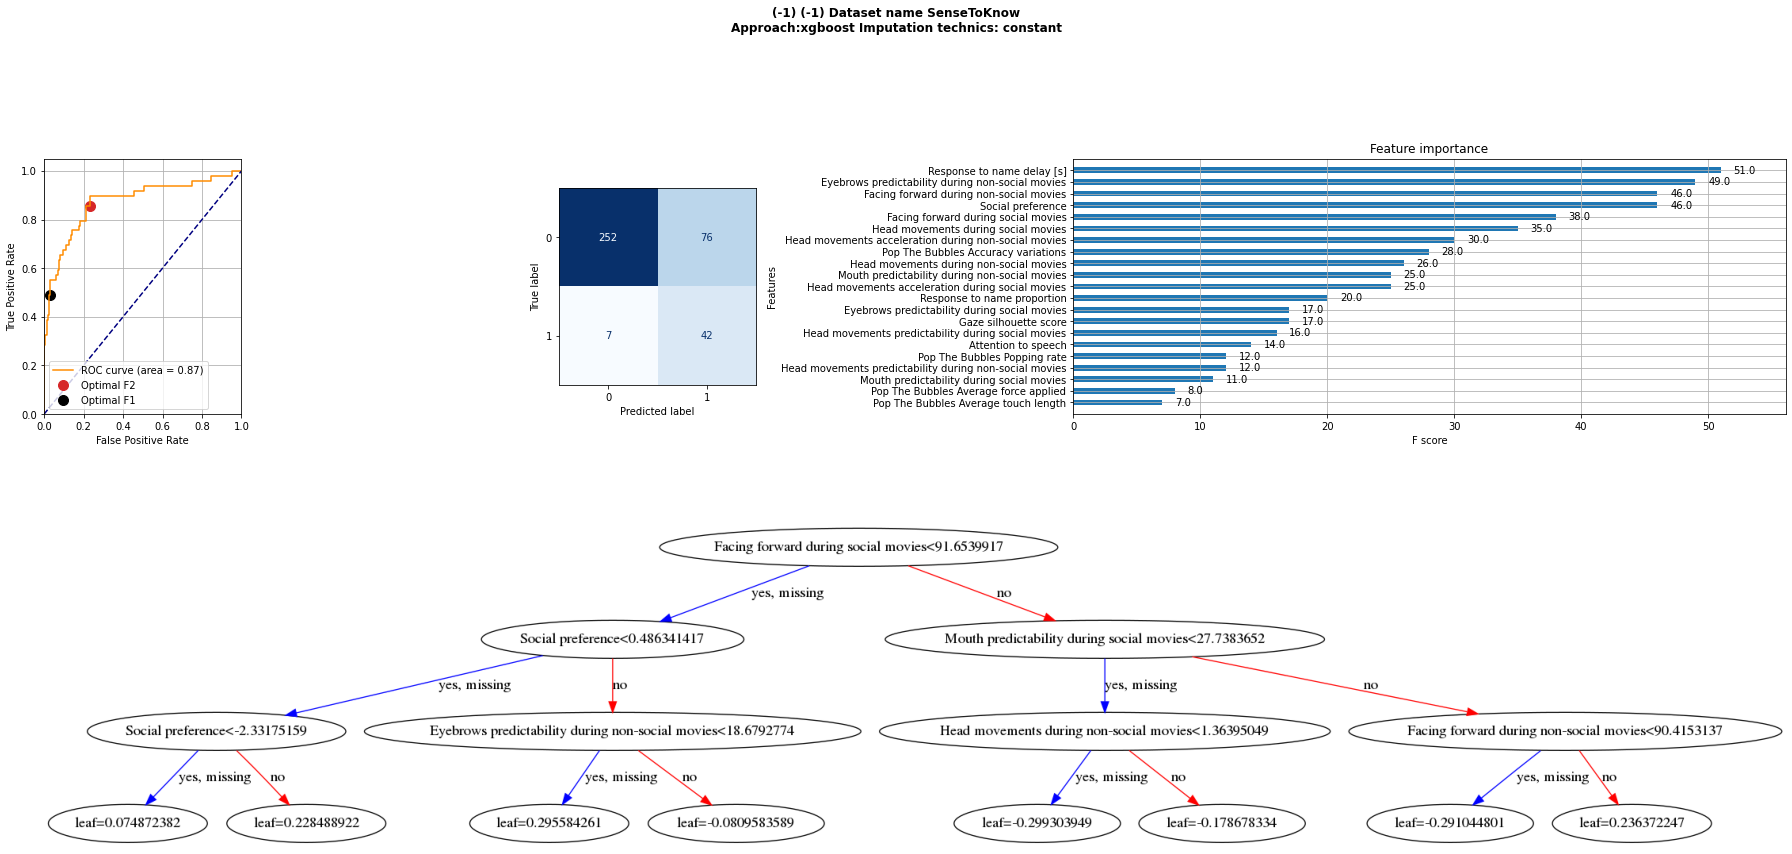

In [7]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
    
use_weight = True
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    

df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='15_December_final_regular_weighted_K50', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'Supreme',
                  verbosity=1, 
                  save_experiment=False)

exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score, random_state=47)
#exp.predictions_df['sample_weight'] = weighted_confidence_score
exp.plot()

**Retrieve their quality score and conclusiveness score**

In [89]:
quality_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))
conslusiveness_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'conclusiveness_asd_nt.npy'))

exp.predictions_df['conslusiveness_score'] = conslusiveness_score
exp.predictions_df['quality_score'] = quality_score

**Compute Shap Values using the experiment that were run with all features, in the `paper_uncertianinty` notebook**

In [10]:
exp_path = '/home01/sam/notes_on_stats/doc/src/data/15_December_Final_With_Weight/SenseToKnow/'
json_paths = glob(os.path.join(exp_path, '*', 'experiment*.json'))
i = 0
shap_interactions_all_cv = []
for json_path in json_paths:
    #try:
        
    with open(json_path, 'r') as f:
        data = json.load(f)

    shap_interactions_all_cv.append([np.array(data['shap_interaction_value'])])
    # except:
    #     print("Error parsing json")


shap_interactions = np.concatenate(shap_interactions_all_cv)

# Normalize the Shap Values for each sample so that there are comparables. 
shap_interactions_normalized = shap_interactions / np.abs(shap_interactions).sum(axis=3).sum(axis=2)[:, :, np.newaxis, np.newaxis]

# Average the Shap values over the different experiments 
averaged_shap_interactions = shap_interactions_normalized.mean(axis=0)

# Re-normalize the Shap values
averaged_shap_interactions_normalized  = averaged_shap_interactions/np.abs(averaged_shap_interactions).sum(axis=2).sum(axis=1)[:, np.newaxis, np.newaxis]

In [39]:
principal_effect_sum = np.mean([np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])
principal_effect_sum_std = np.std([np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])

interaction_effect_sum = np.mean([np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])
interaction_effect_sum_std = np.std([np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])

print("Principal contribution of each features: {:.3f} (+/- {:.3f}), and interaction effect: {:.3f} (+- {:.3f}%)".format(principal_effect_sum, principal_effect_sum_std, interaction_effect_sum, interaction_effect_sum_std ))





Principal contribution of each features: 0.633 (+/- 0.028), and interaction effect: 0.367 (+- 0.028%)


**Select a promising participant to showcase**

mean_gaze_percent_right  gaze_silhouette_score  FP_gaze_speech_correlation  proportion_of_name_call_responses  average_response_to_name_delay  S_postural_sway  NS_postural_sway  S_postural_sway_derivative  NS_postural_sway_derivative  S_postural_sway_complexity  NS_postural_sway_complexity  S_facing_forward  NS_facing_forward  S_eyebrows_complexity  NS_eyebrows_complexity  S_mouth_complexity  NS_mouth_complexity  pop_rate  std_error  average_length  average_force_applied  y_true    y_pred  TN  TP  FP  FN pred_class  conslusiveness_score  quality_score
66                  0.419339               0.461836                    0.025305                           0.333333                        0.934267         5.002257          1.275072                    0.030330                     0.005013                    2.487151                     1.609438         48.524315          60.136997              20.929317               26.090395           18.125196            26.626478       1.0   4.490219        6.071926               0.055451     1.0  0.994025   0   1   0   0         TP                   1.0       0.955819
98                  0.457387               0.420705                    0.000000                           0.000000                             NaN         1.519707          0.711399                    0.007870                     0.004935                         NaN                          NaN               NaN                NaN                    NaN                     NaN                 NaN                  NaN       NaN        NaN             NaN                    NaN     1.0  0.992723   0   1   0   0         TP                   1.0       0.378131
7                   0.453969               0.474159                    0.154801                           0.333333                        0.800800         1.202935          0.689981                    0.004858                     0.002394                    1.649400                     1.137150         85.985664          87.071715              36.649902               30.227022           31.675351            28.408193       0.0   5.046605       97.658653               0.057314     1.0  0.986190   0   1   0   0         TP                   1.0       0.941092
244                 0.366051               0.464882                    0.069980                           1.000000                        3.236567         2.678807          4.166302                    0.012241                     0.020952                    2.063806                     0.000000         69.622629          71.164903              26.893896               30.654011           26.634375            29.092157       0.0   6.151388       44.210309               0.226617     1.0  0.976522   0   1   0   0         TP                   1.0       0.924926
225                 0.449571               0.421093                    0.266021                           0.666667                        1.418083         0.505882          0.806044                    0.002831                     0.007551                         NaN                          NaN               NaN                NaN                    NaN                     NaN                 NaN                  NaN       NaN        NaN             NaN                    NaN     1.0  0.971925   0   1   0   0         TP                   1.0       0.485108

pred_class  quality_score  conslusiveness_score
66         TP       0.955819                   1.0

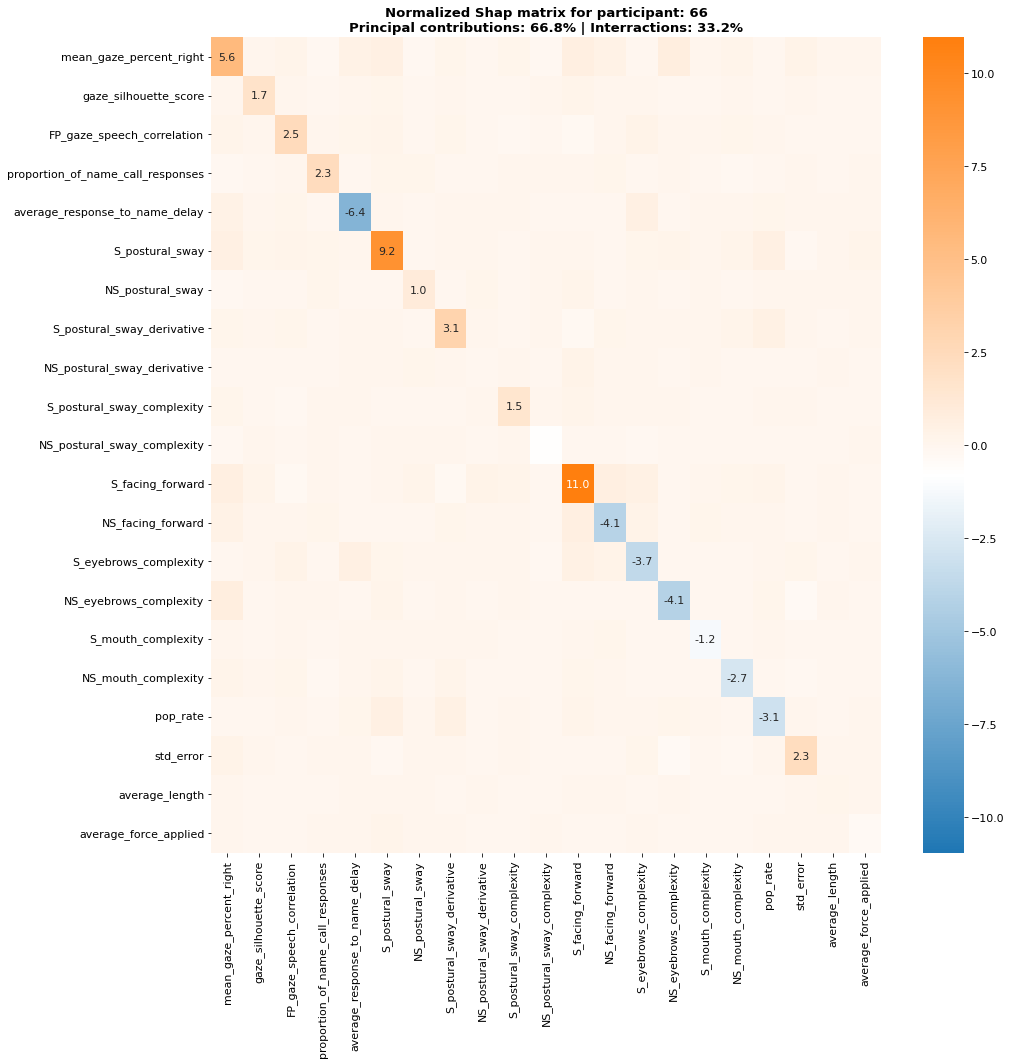

total       main interaction first_interaction          first_interaction_name
S_facing_forward                   14.694459  10.957314    3.737146          0.659797         mean_gaze_percent_right
S_postural_sway                    12.072061   9.223914    2.848147          0.590372                        pop_rate
mean_gaze_percent_right             9.898343   5.553148    4.345196          0.712388          NS_eyebrows_complexity
average_response_to_name_delay      8.026226   6.383212    1.643014          0.580057           S_eyebrows_complexity
NS_facing_forward                   6.178979    4.07853    2.100449           0.60222                S_facing_forward
S_eyebrows_complexity               6.074235   3.674974    2.399261          0.580057  average_response_to_name_delay
NS_eyebrows_complexity              5.827933   4.132558    1.695375          0.712388         mean_gaze_percent_right
pop_rate                            4.883767   3.068035    1.815732          0.590372                 S_postural_sway
S_postural_sway_derivative          4.761171   3.143527    1.617644          0.442873                        pop_rate
FP_gaze_speech_correlation          4.219777   2.475585    1.744192          0.286512           S_eyebrows_complexity
NS_mouth_complexity                 4.161348   2.712994    1.448353          0.252039         mean_gaze_percent_right
std_error                           3.666682   2.254846    1.411836           0.28635         mean_gaze_percent_right
proportion_of_name_call_responses   3.278198   2.336677    0.941521          0.155155               NS_facing_forward
gaze_silhouette_score               2.652364   1.719347    0.933017          0.243075                S_facing_forward
S_postural_sway_complexity          2.322084    1.50401    0.818074          0.181104                S_facing_forward
NS_postural_sway                    1.931437   1.017248    0.914188          0.247483                S_facing_forward
S_mouth_complexity                  1.868187   1.207445    0.660742          0.106707               NS_facing_forward
NS_postural_sway_complexity         1.363094    0.74644    0.616653          0.131207           S_eyebrows_complexity
NS_postural_sway_derivative         0.951016   0.078656     0.87236          0.298242                S_facing_forward
average_force_applied               0.710688   0.330938     0.37975           0.17288                 S_postural_sway
average_length                      0.457952   0.161429    0.296523          0.053772                 S_postural_sway
SUM                                      100  66.760825   33.239175

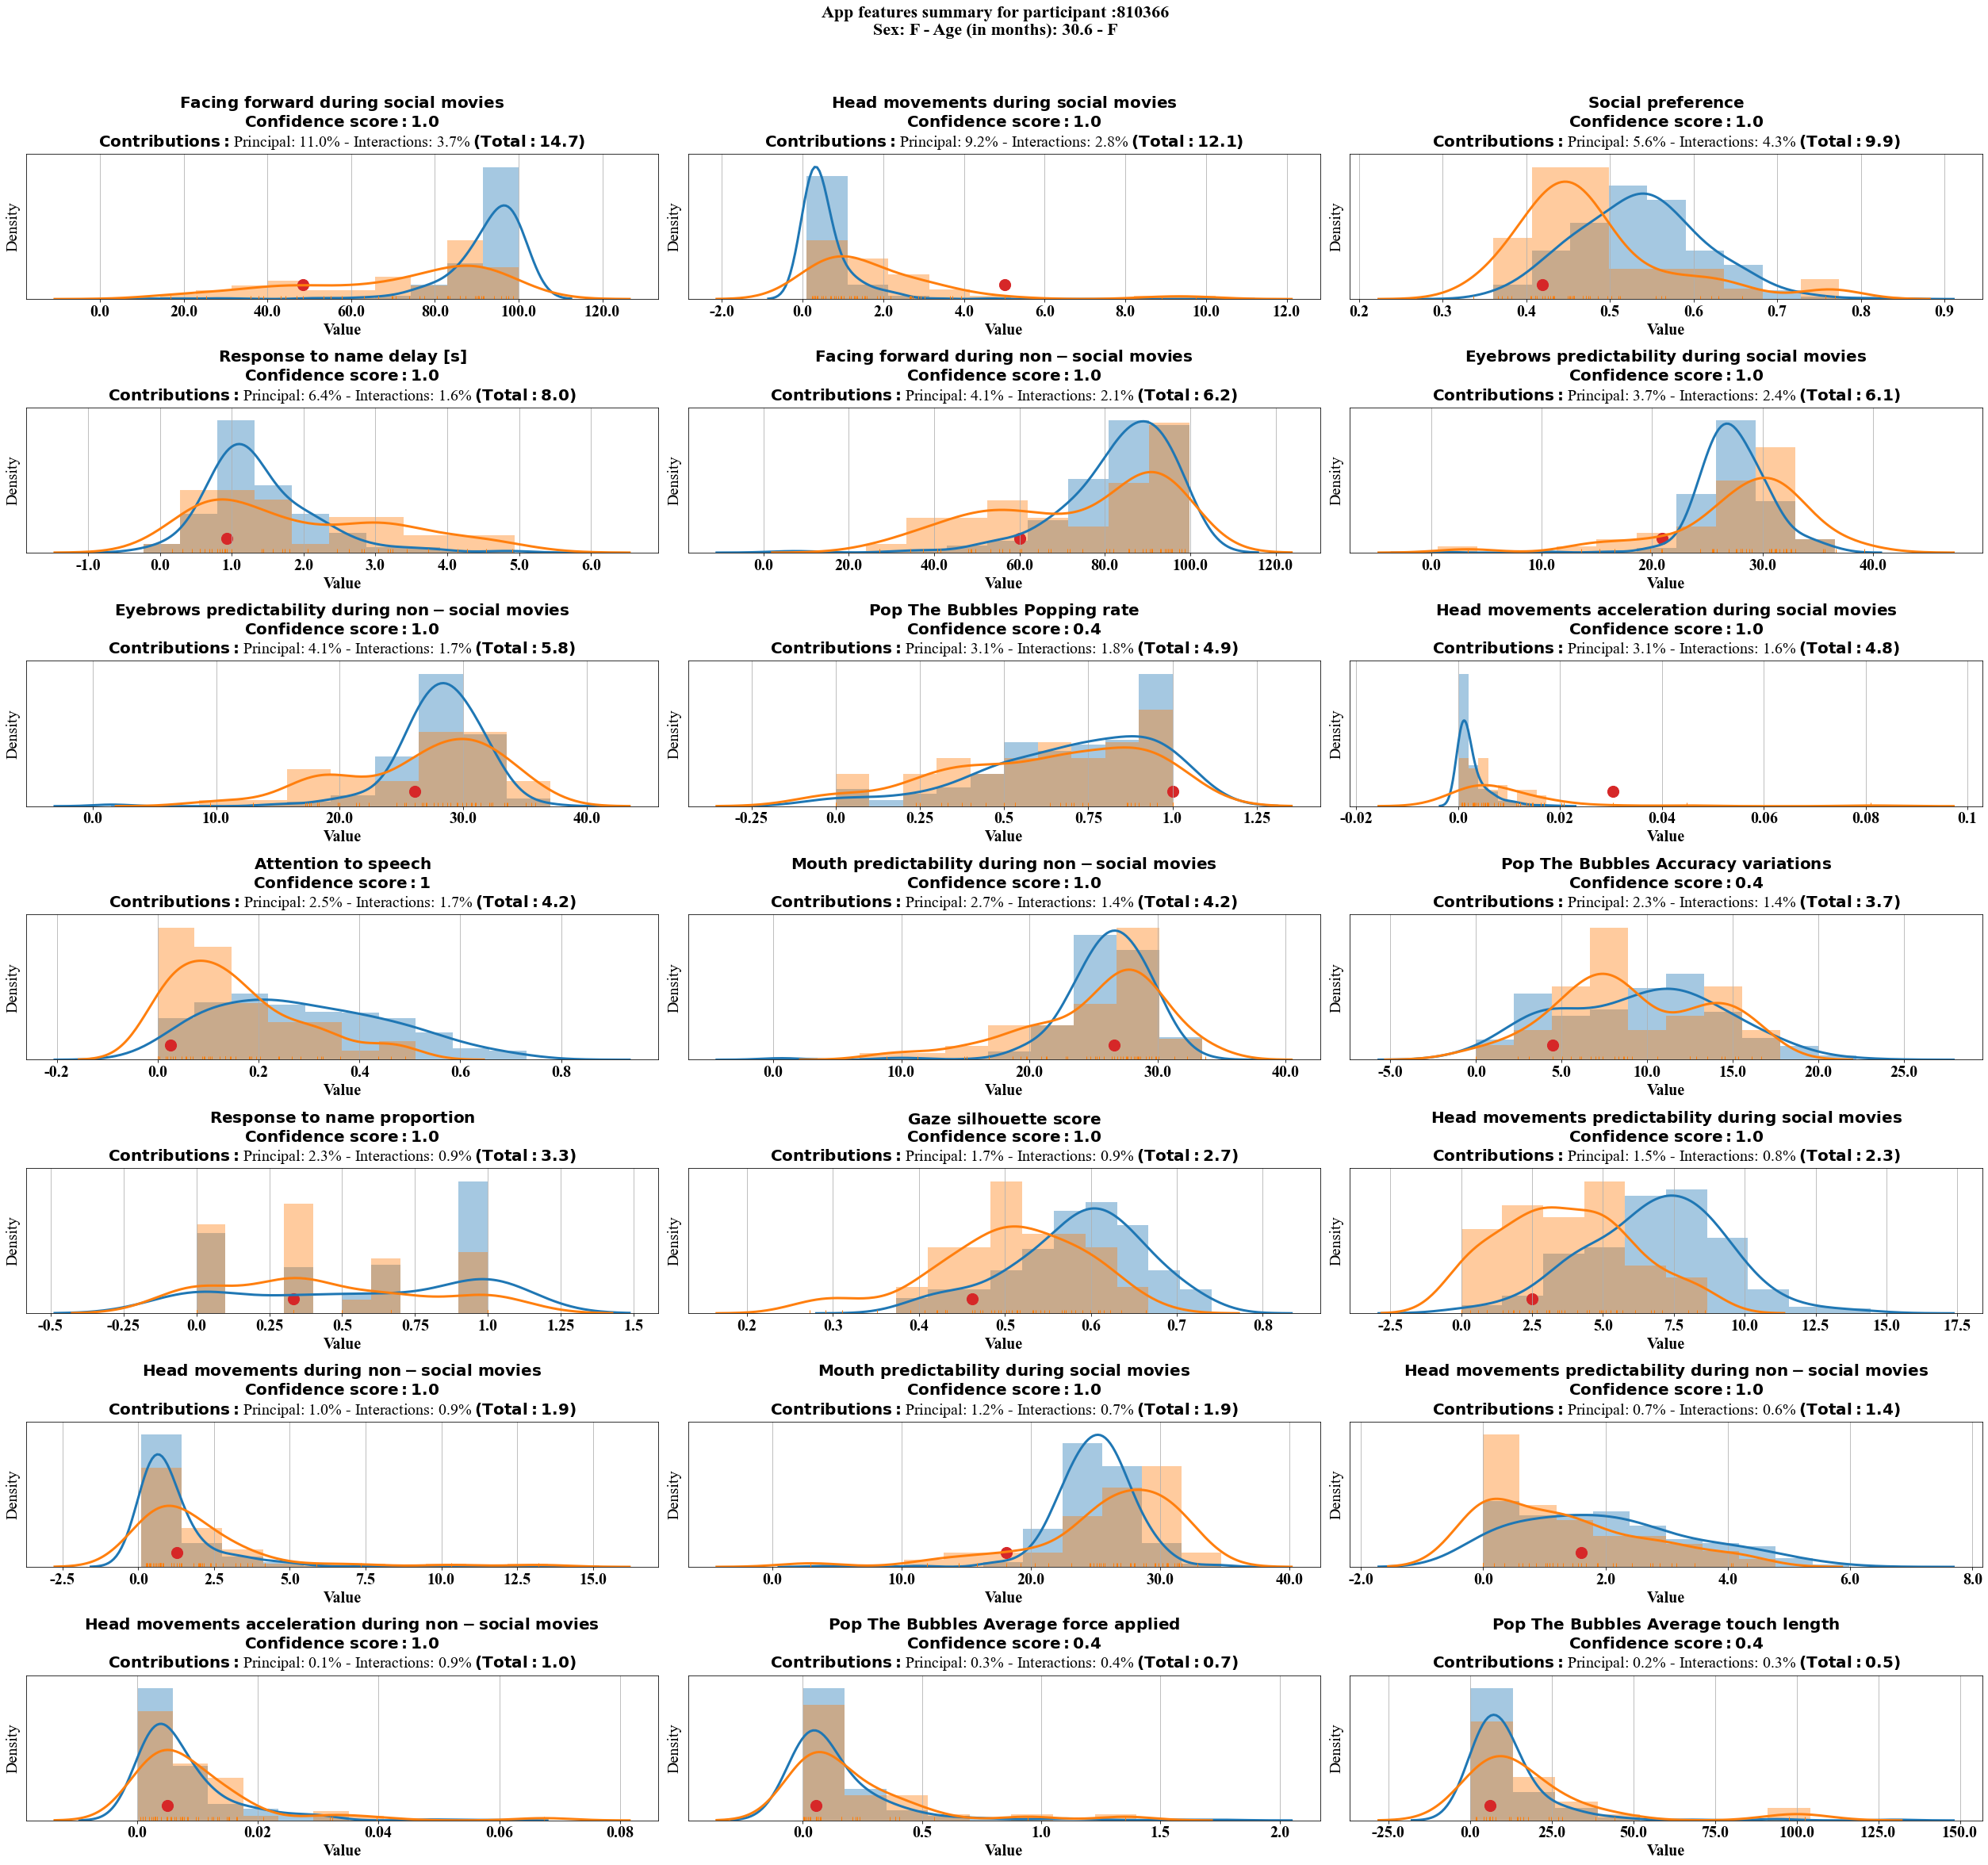

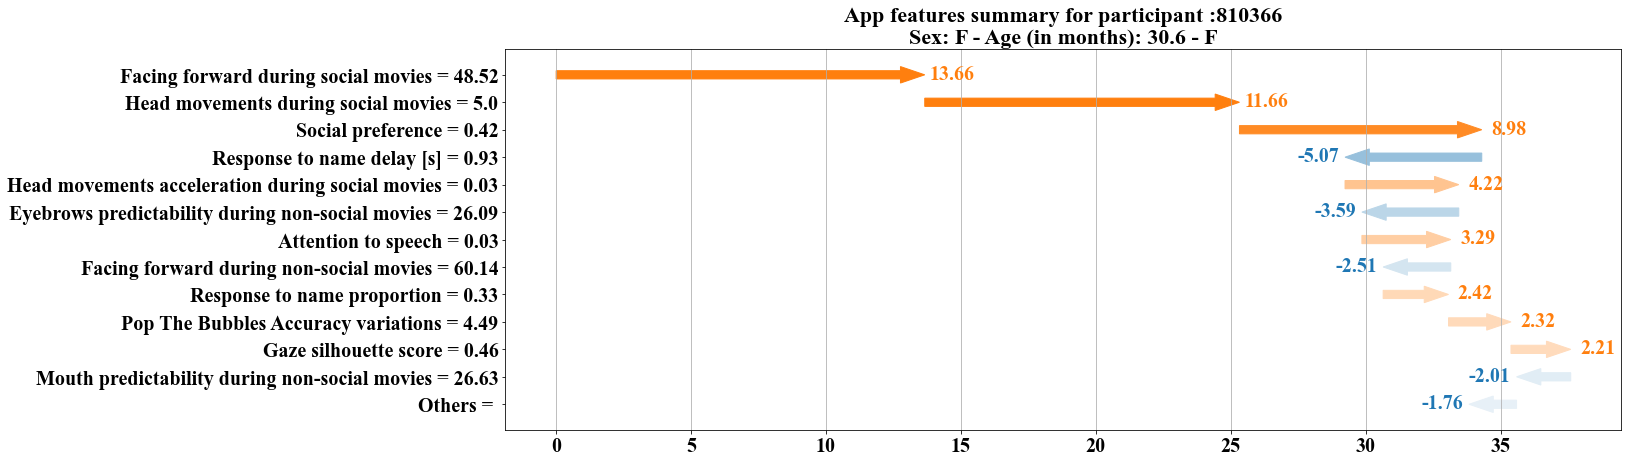

Facing forward during social movies: 1.00
Head movements during social movies: 1.00
Social preference: 1.00
Response to name delay [s]: 1.00
Head movements acceleration during social movies: 1.00
Eyebrows predictability during non-social movies: 1.00
Attention to speech: 1.00
Facing forward during non-social movies: 1.00
Response to name proportion: 1.00
Pop The Bubbles Accuracy variations: 0.40
Gaze silhouette score: 1.00
Mouth predictability during non-social movies: 1.00



In [91]:
display(exp.predictions_df.sort_values(by='y_pred', ascending=False).head())
index_sample = 66
display(exp.predictions_df.iloc[index_sample:index_sample+1][['pred_class', 'quality_score', 'conslusiveness_score']])
report_participant(exp, index_sample)

**Show a NT participant**

mean_gaze_percent_right  gaze_silhouette_score  FP_gaze_speech_correlation  proportion_of_name_call_responses  average_response_to_name_delay  S_postural_sway  NS_postural_sway  S_postural_sway_derivative  NS_postural_sway_derivative  S_postural_sway_complexity  NS_postural_sway_complexity  S_facing_forward  NS_facing_forward  S_eyebrows_complexity  NS_eyebrows_complexity  S_mouth_complexity  NS_mouth_complexity  pop_rate  std_error  average_length  average_force_applied  y_true    y_pred  TN  TP  FP  FN pred_class  conslusiveness_score  quality_score
153                 0.540292               0.577948                    0.430331                           1.000000                        1.779556         0.255543          0.704238                    0.001554                     0.011690                    9.870011                     2.254627         98.543689          85.537404              26.191059               28.812306           22.365965            23.725949  0.928571   5.413515        4.960431               0.085651     0.0  0.000007   1   0   0   0         TN                   0.0       0.995091
165                 0.630810               0.721111                    0.668531                           0.666667                        2.035367         0.233596          0.728732                    0.000740                     0.005542                    5.511115                     1.298239         96.700975          64.141877              26.932376               29.672455           20.234962            23.523943  0.941176  10.705549        4.050845               0.042878     0.0  0.000029   1   0   0   0         TN                   0.0       1.000000
328                 0.520488               0.674150                    0.258697                           1.000000                        1.812922         0.438410          0.542593                    0.001974                     0.003893                    6.638268                     0.583844         93.502822          86.335386              26.877170               27.946779           24.319677            24.551013  0.625000   6.619117       12.939835               0.206473     0.0  0.000041   1   0   0   0         TN                   0.0       0.965637
339                 0.539326               0.464642                    0.404832                           1.000000                        1.034367         0.434143          1.507138                    0.002137                     0.018569                    4.562822                     0.708303         99.236147          85.291326              25.185959               28.203448           24.417246            29.084864  0.900000  11.203719       41.534737               0.393037     0.0  0.000043   1   0   0   0         TN                   0.0       0.924926
133                 0.636777               0.740519                    0.530631                           1.000000                        1.178956         0.148035          0.596606                    0.000241                     0.002584                   11.099342                     1.135824        100.000000          89.638459              25.189997               26.388252           29.659001            31.118704  1.000000   0.843956        0.160349               0.008533     0.0  0.000045   1   0   0   0         TN                   0.0       0.941092

pred_class  quality_score  conslusiveness_score
165         TN            1.0                   0.0

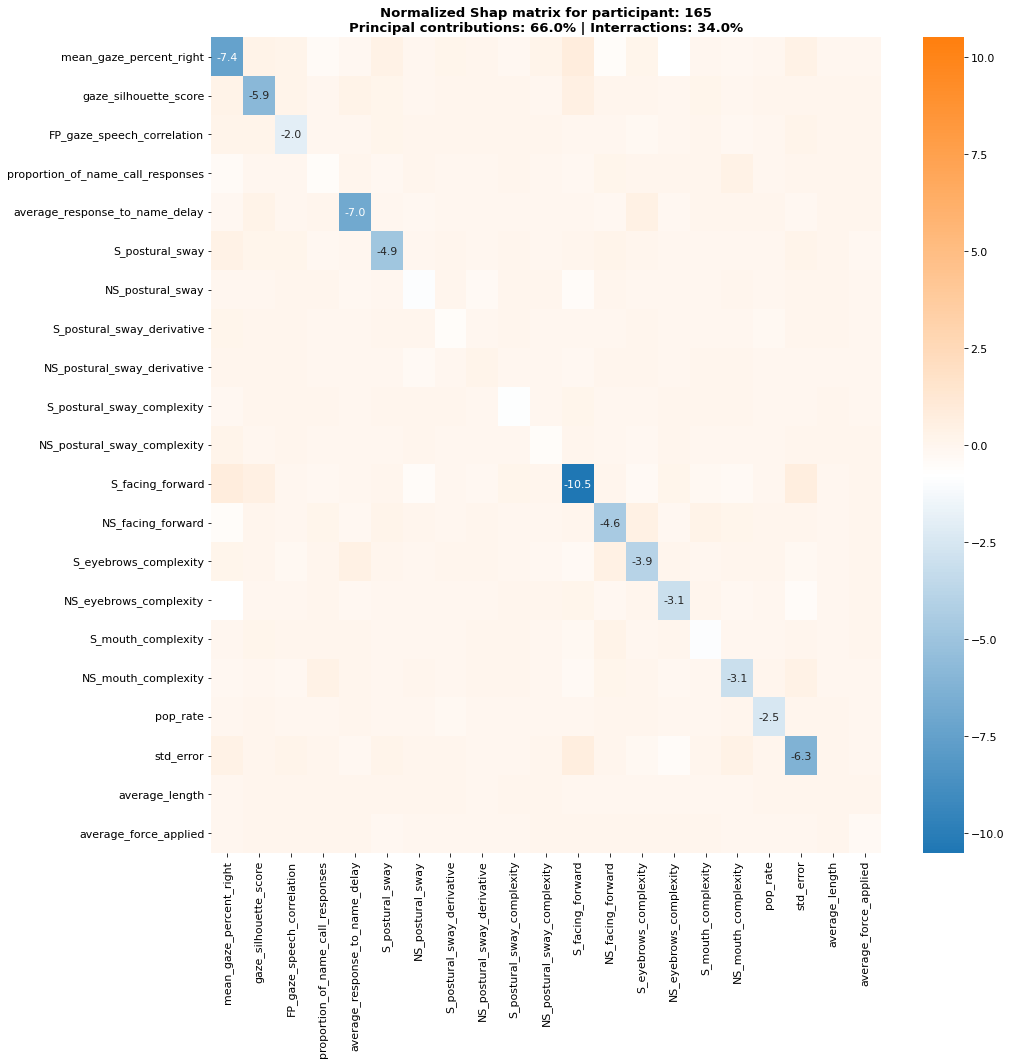

total       main interaction first_interaction             first_interaction_name
S_facing_forward                   14.589692  10.509731    4.079961          0.804442            mean_gaze_percent_right
mean_gaze_percent_right             12.04644   7.411254    4.635186          0.804442                   S_facing_forward
std_error                           9.441804   6.295827    3.145977           0.72668                   S_facing_forward
average_response_to_name_delay      8.763046   6.979094    1.783952          0.481172              S_eyebrows_complexity
gaze_silhouette_score               7.812697   5.907008    1.905689          0.497171                   S_facing_forward
NS_facing_forward                   6.639745   4.592142    2.047603          0.520515            mean_gaze_percent_right
S_postural_sway                      6.51778   4.870564    1.647216          0.374286            mean_gaze_percent_right
S_eyebrows_complexity               6.065113   3.940349    2.124765          0.481172     average_response_to_name_delay
NS_eyebrows_complexity              5.070847   3.079658     1.99119          0.760128            mean_gaze_percent_right
NS_mouth_complexity                 4.892424   3.091419    1.801005          0.366642  proportion_of_name_call_responses
FP_gaze_speech_correlation          3.429887    2.02295    1.406937          0.218915                          std_error
pop_rate                            3.265091   2.527834    0.737257          0.169405         S_postural_sway_derivative
NS_postural_sway                    2.005919   0.906328    1.099591          0.460678                   S_facing_forward
proportion_of_name_call_responses    1.93565   0.495831     1.43982           0.39317            mean_gaze_percent_right
S_mouth_complexity                  1.909012    0.93159    0.977422          0.247401                  NS_facing_forward
S_postural_sway_complexity          1.428876   0.877204    0.551672          0.128201                   S_facing_forward
S_postural_sway_derivative          1.210081   0.494034    0.716046          0.169405                           pop_rate
NS_postural_sway_complexity         1.088617   0.498508    0.590109          0.199842            mean_gaze_percent_right
NS_postural_sway_derivative         0.844093   0.193362    0.650732           0.26231                   NS_postural_sway
average_force_applied               0.806712   0.310854    0.495858          0.129581                    S_postural_sway
average_length                      0.236473   0.022351    0.214122          0.043731            mean_gaze_percent_right
SUM                                      100   65.95789    34.04211

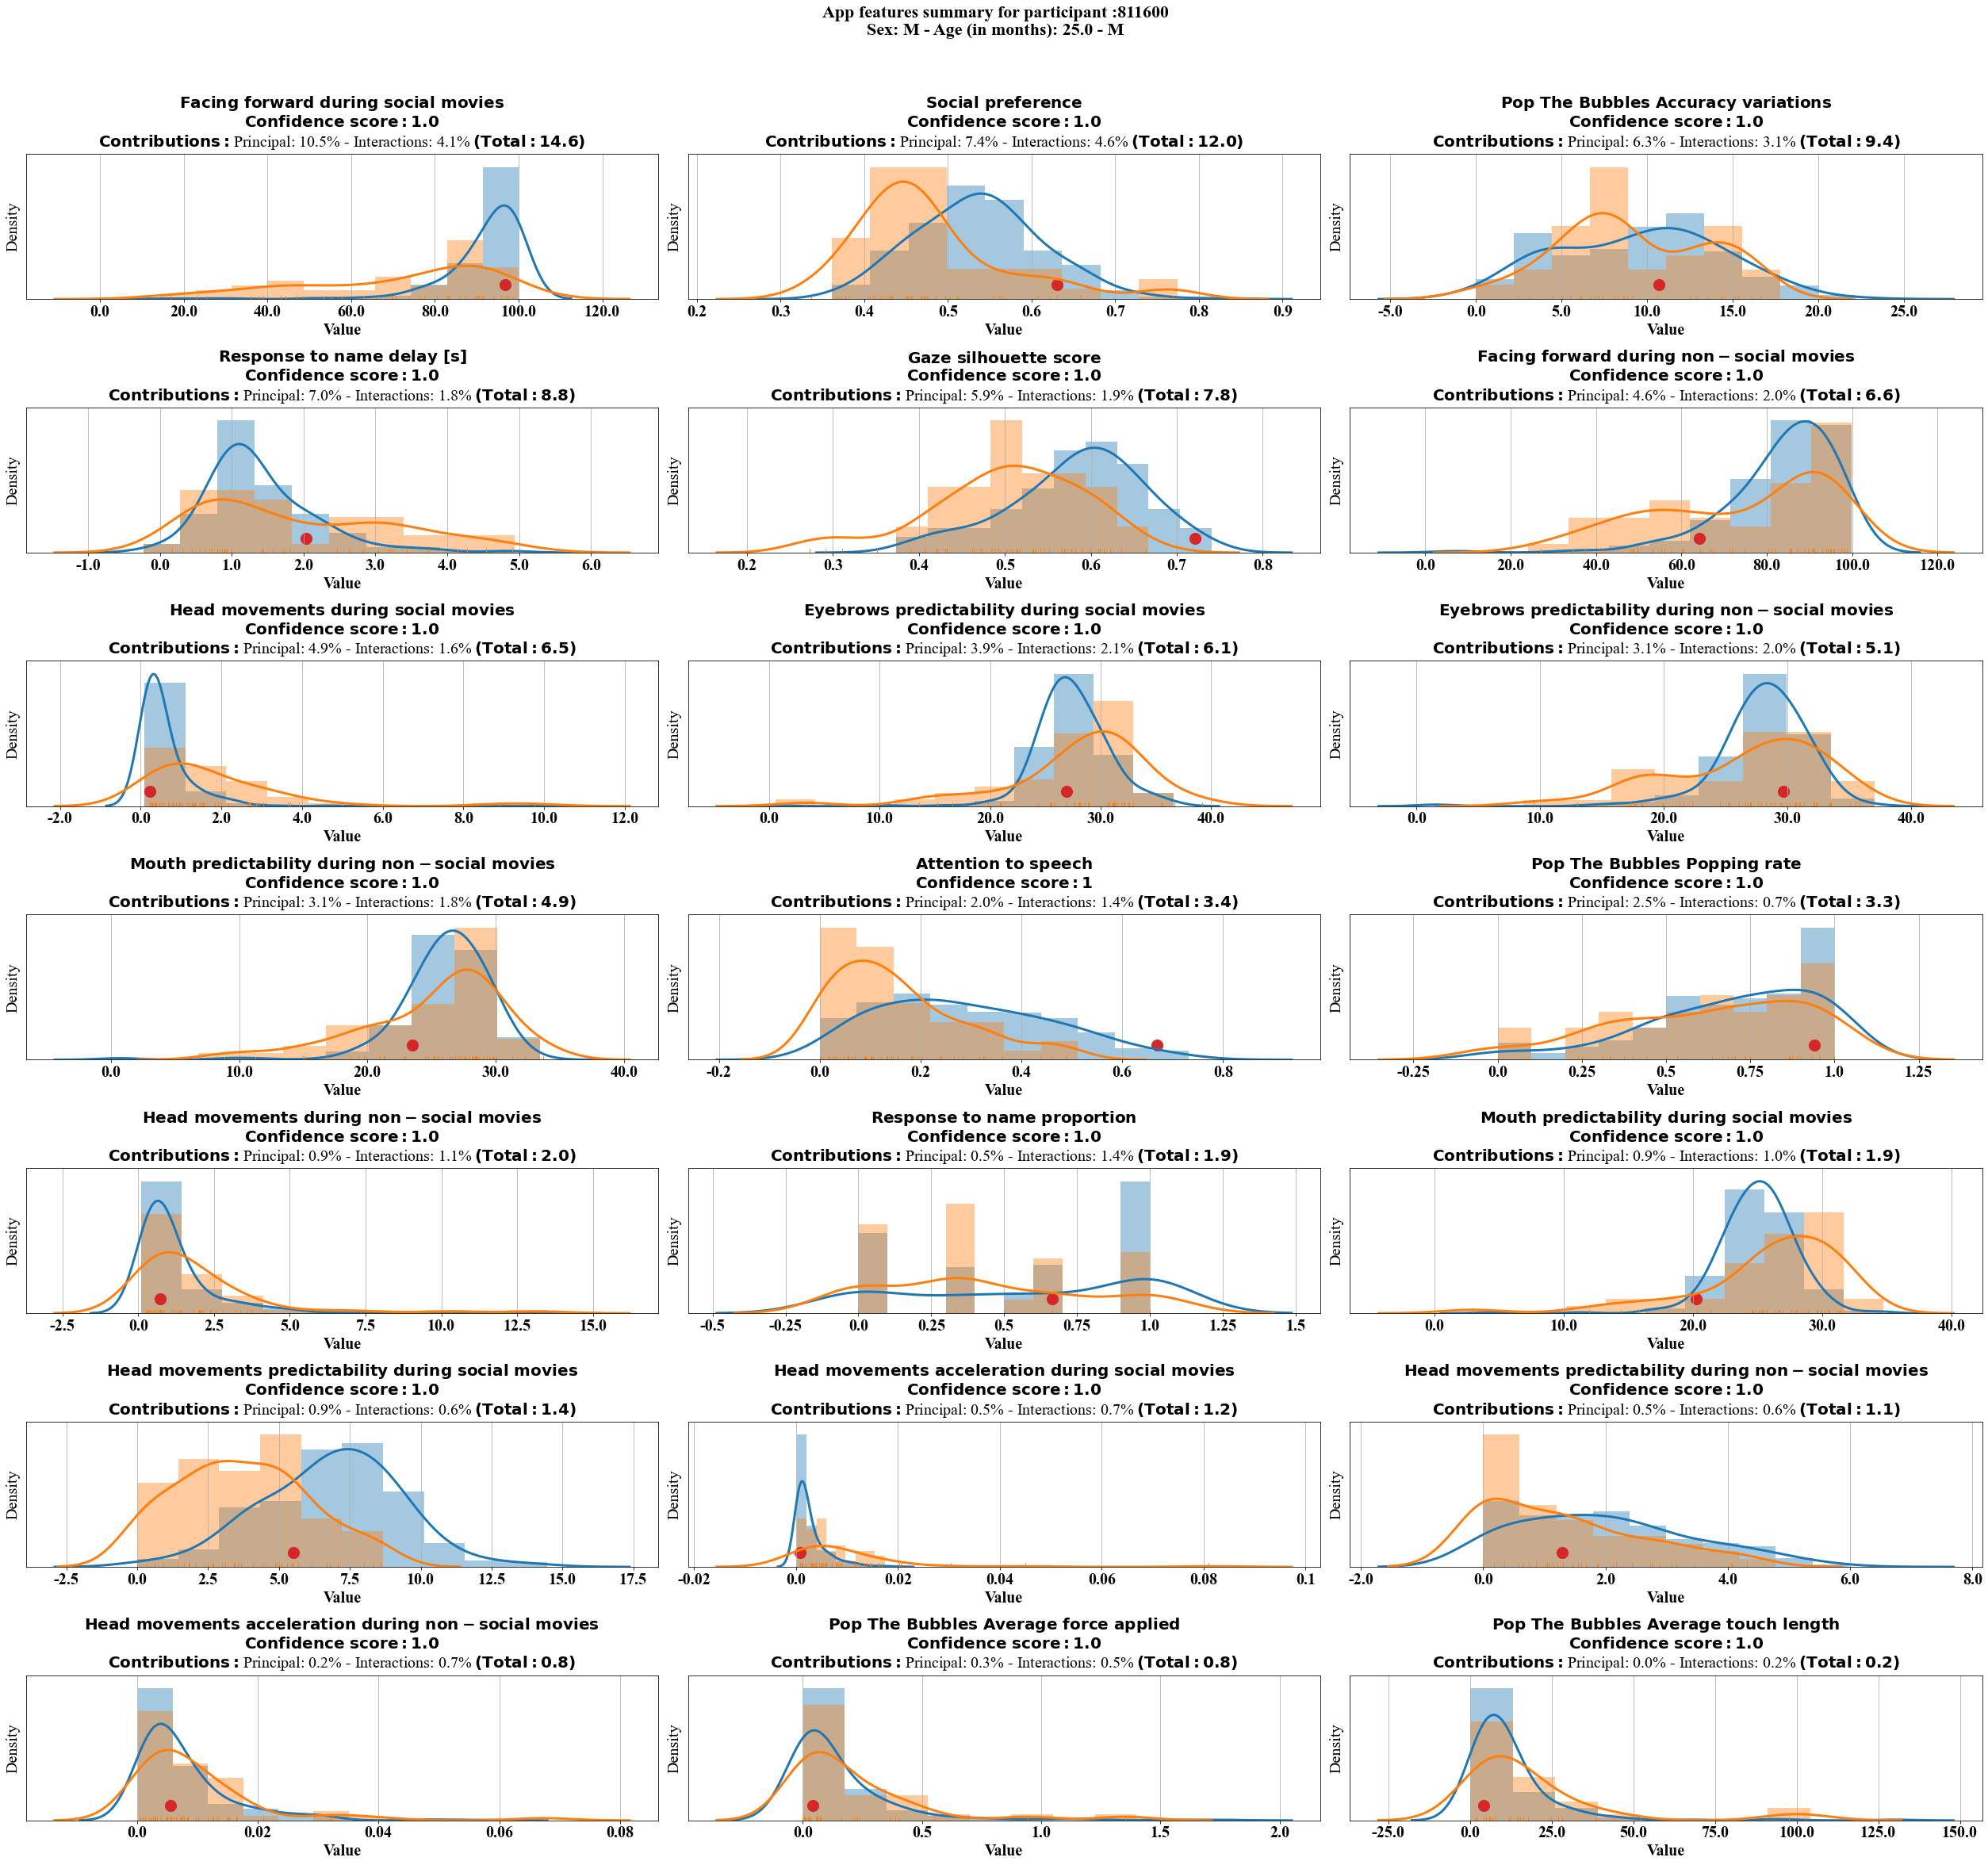

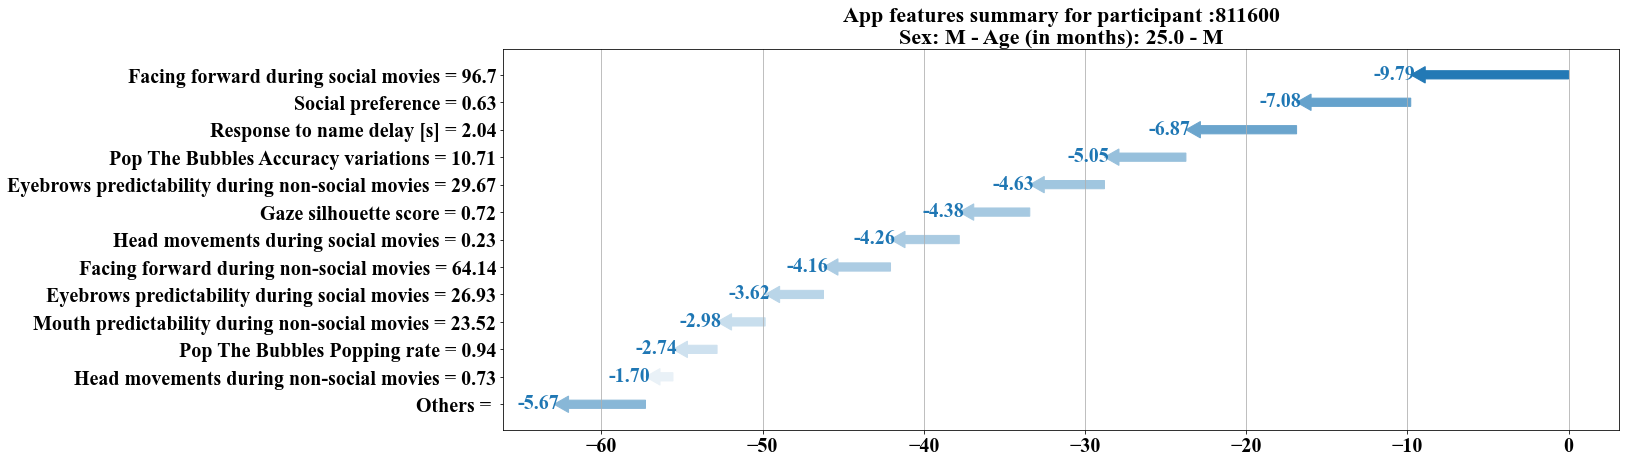

Facing forward during social movies: 1.00
Social preference: 1.00
Response to name delay [s]: 1.00
Pop The Bubbles Accuracy variations: 1.00
Eyebrows predictability during non-social movies: 1.00
Gaze silhouette score: 1.00
Head movements during social movies: 1.00
Facing forward during non-social movies: 1.00
Eyebrows predictability during social movies: 1.00
Mouth predictability during non-social movies: 1.00
Pop The Bubbles Popping rate: 1.00
Head movements during non-social movies: 1.00



In [92]:
display(exp.predictions_df.sort_values(by='y_pred', ascending=True).head())
index_sample = 165
display(exp.predictions_df.iloc[index_sample:index_sample+1][['pred_class', 'quality_score', 'conslusiveness_score']])

report_participant(exp, index_sample)

**Show hard to classiffy ASD without MCHAT**

pred_class  quality_score  conslusiveness_score
47         TP       0.926365                  0.36

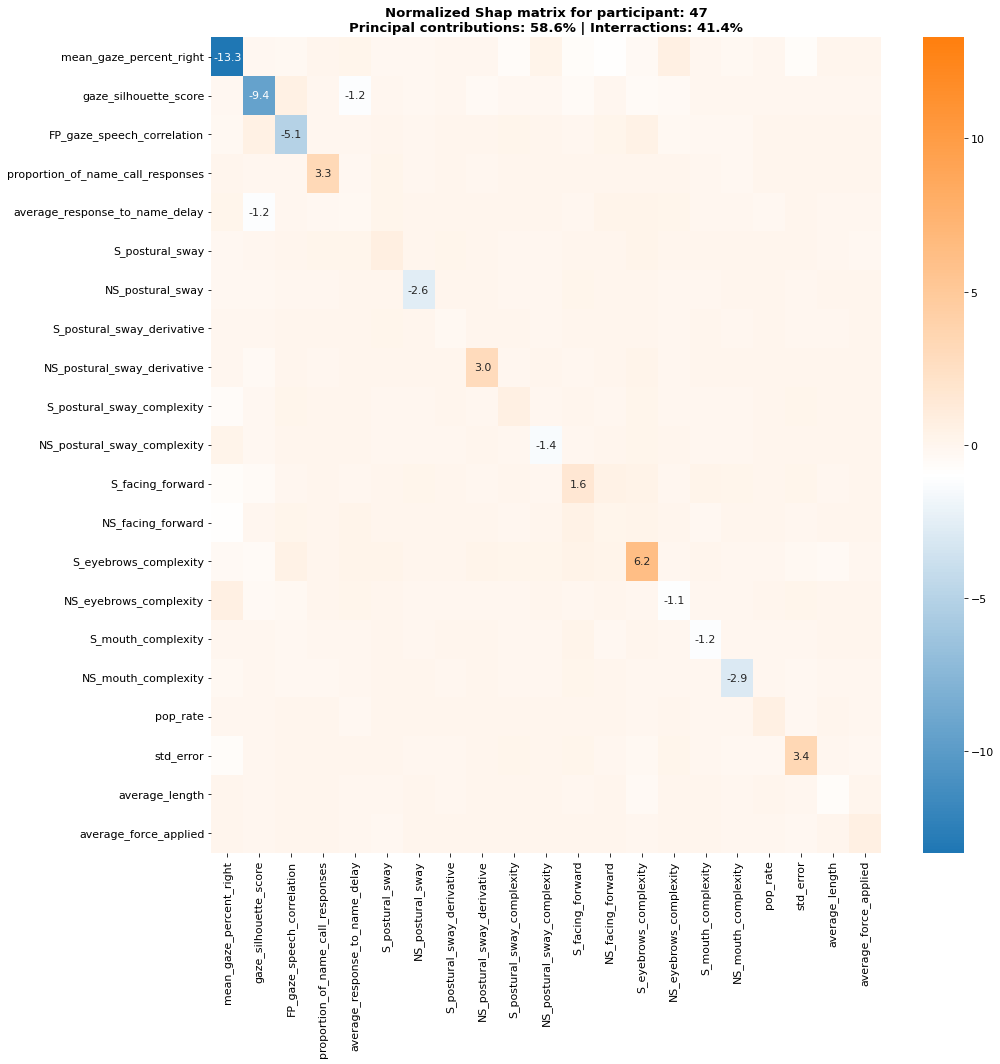

total       main interaction first_interaction          first_interaction_name
mean_gaze_percent_right            19.017375  13.301162    5.716213          0.910924               NS_facing_forward
gaze_silhouette_score              13.729638   9.388883    4.340755          1.239306  average_response_to_name_delay
S_eyebrows_complexity               9.914552   6.153926    3.760626           0.47294           gaze_silhouette_score
FP_gaze_speech_correlation          7.667568   5.058454    2.609114          0.546585           gaze_silhouette_score
std_error                           5.728807   3.387223    2.341583          0.712346         mean_gaze_percent_right
S_facing_forward                    4.603024   1.591179    3.011845          0.648791         mean_gaze_percent_right
proportion_of_name_call_responses     4.3016   3.254605    1.046994          0.187282                 S_postural_sway
NS_mouth_complexity                 4.209156   2.933858    1.275299          0.285402         mean_gaze_percent_right
NS_postural_sway_derivative         4.099158   2.963529     1.13563          0.389283           gaze_silhouette_score
NS_postural_sway                    3.347183     2.6399    0.707283          0.179754           gaze_silhouette_score
NS_eyebrows_complexity              3.289387   1.081917     2.20747          0.639738         mean_gaze_percent_right
average_response_to_name_delay      3.143151   0.214765    2.928385          1.239306           gaze_silhouette_score
NS_facing_forward                   2.641496   0.152637    2.488859          0.910924         mean_gaze_percent_right
NS_postural_sway_complexity         2.337026   1.417663    0.919363          0.301106         mean_gaze_percent_right
S_mouth_complexity                  2.239256   1.219799    1.019458          0.273602                S_facing_forward
S_postural_sway                     2.184899   0.761203    1.423695           0.20919           S_eyebrows_complexity
S_postural_sway_complexity          2.127416   0.638968    1.488448          0.618684         mean_gaze_percent_right
average_length                      1.681085   0.715996    0.965089          0.382938           S_eyebrows_complexity
pop_rate                            1.320691    0.69436    0.626331          0.132766  average_response_to_name_delay
average_force_applied                1.30748    0.70646    0.601019          0.123965                       std_error
S_postural_sway_derivative          1.110052   0.299808    0.810244          0.142541                 S_postural_sway
SUM                                      100  58.576295   41.423705

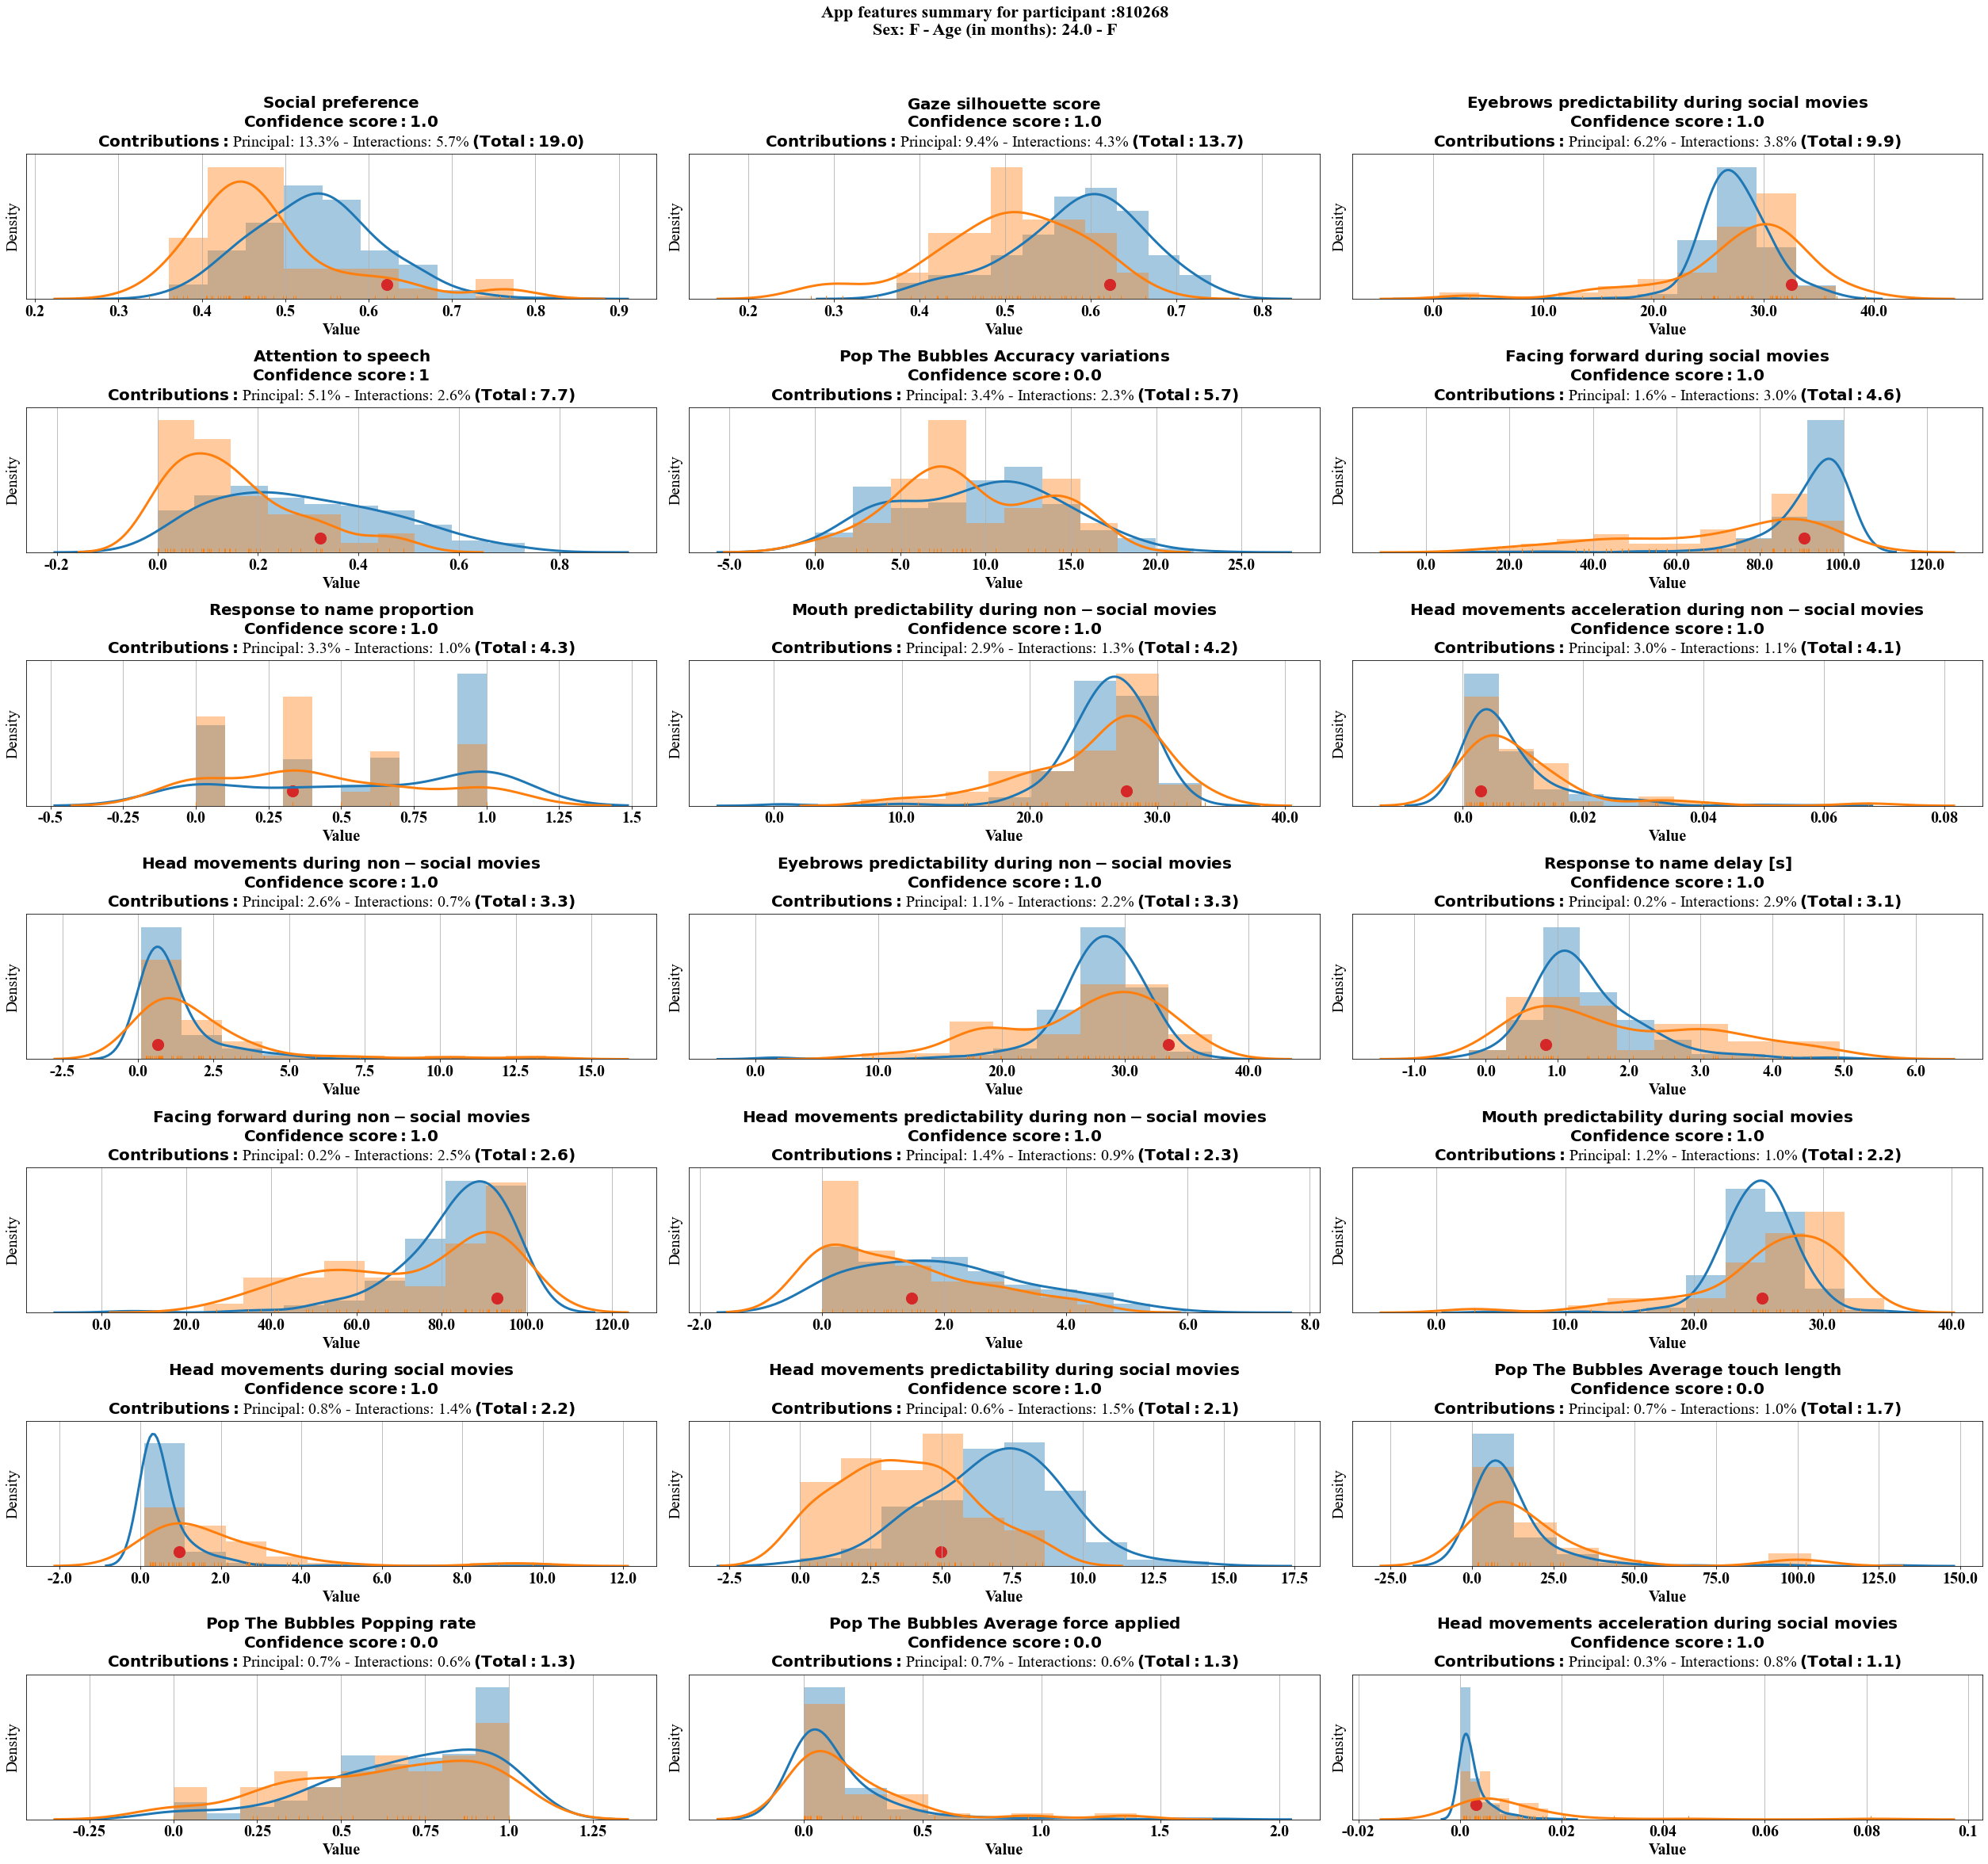

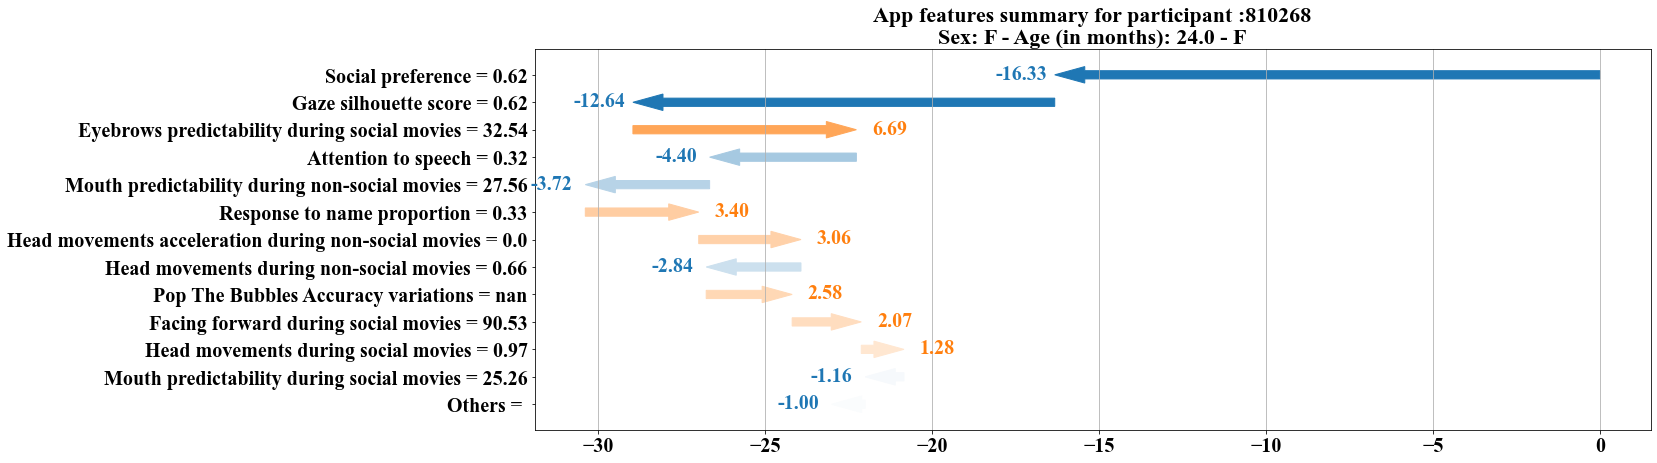

Social preference: 1.00
Gaze silhouette score: 1.00
Eyebrows predictability during social movies: 1.00
Attention to speech: 1.00
Mouth predictability during non-social movies: 1.00
Response to name proportion: 1.00
Head movements acceleration during non-social movies: 1.00
Head movements during non-social movies: 1.00
Pop The Bubbles Accuracy variations: 0.00
Facing forward during social movies: 1.00
Head movements during social movies: 1.00
Mouth predictability during social movies: 1.00



In [93]:
index_sample = 47
display(exp.predictions_df.iloc[index_sample:index_sample+1][['pred_class', 'quality_score', 'conslusiveness_score']])

report_participant(exp, index_sample)

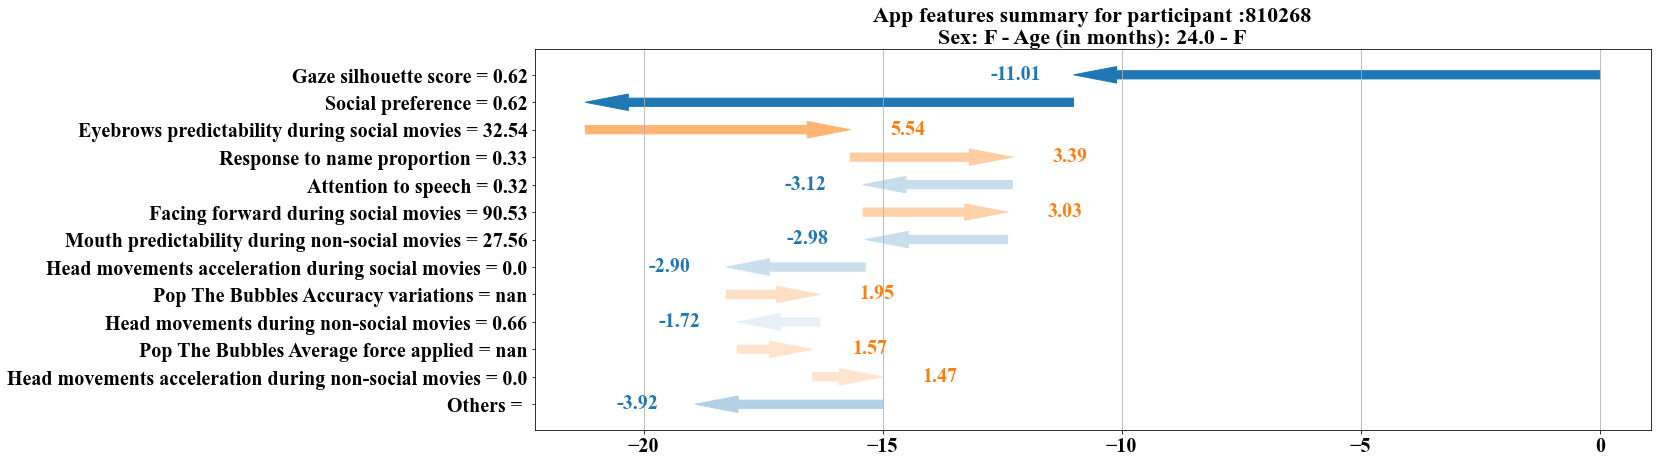

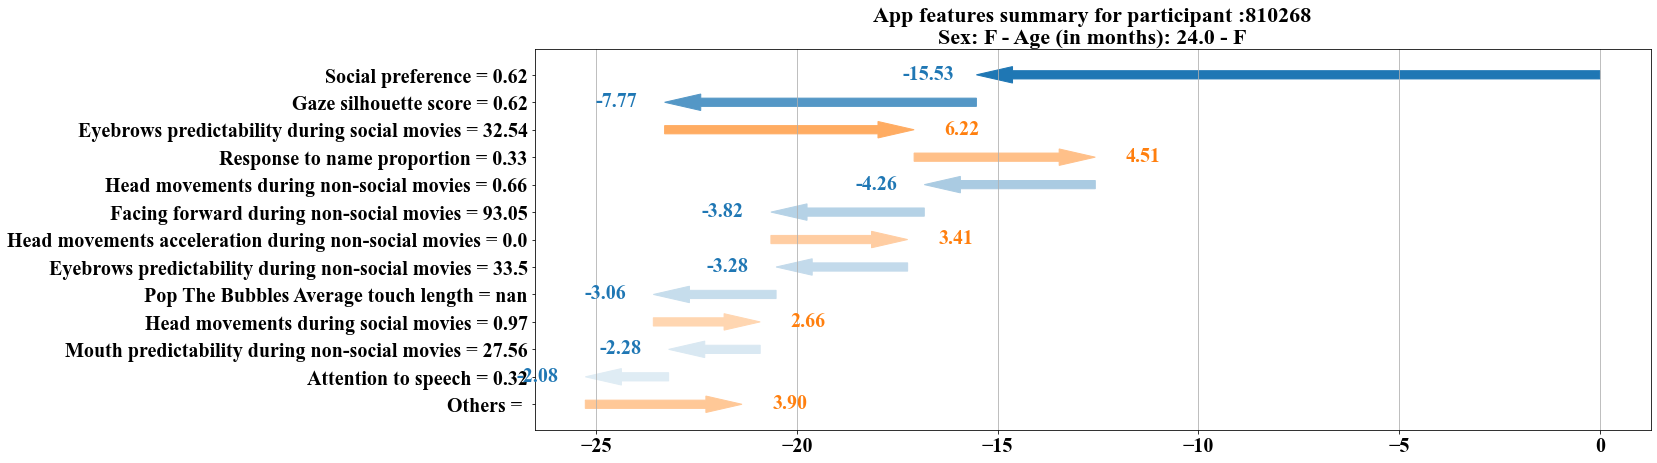

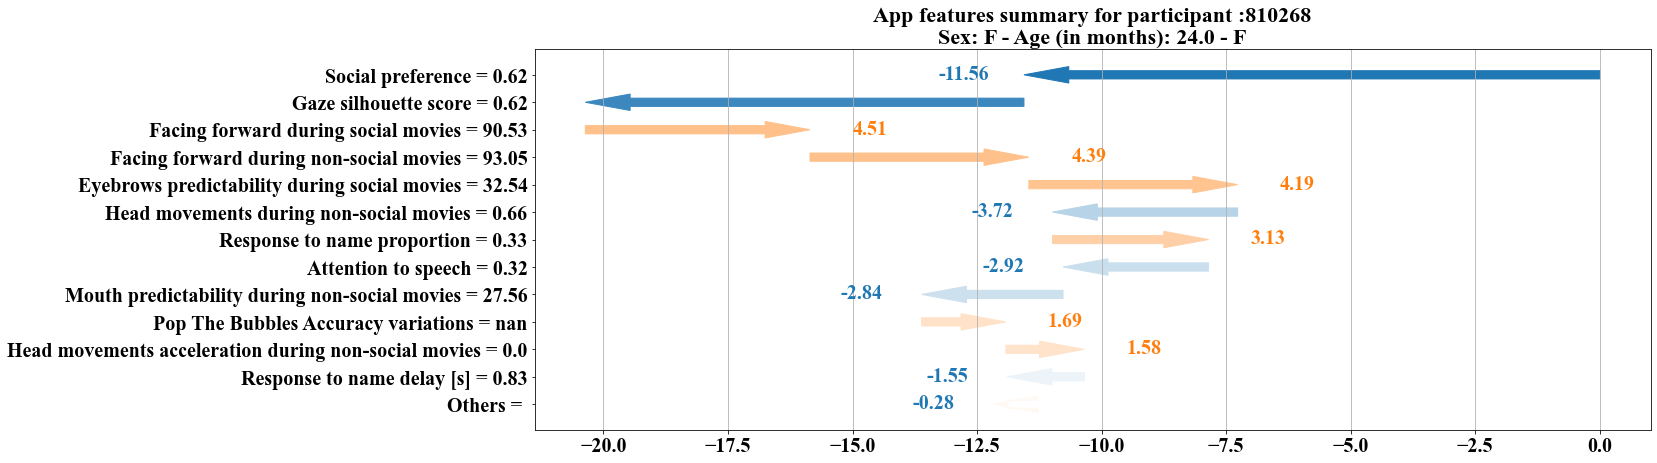

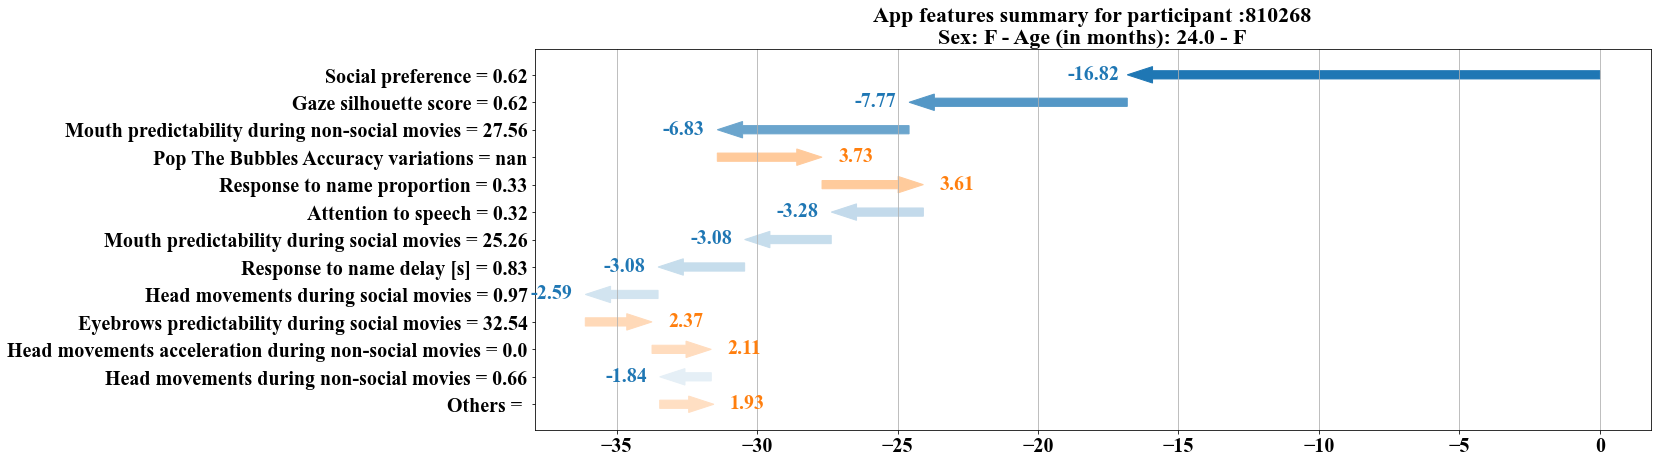

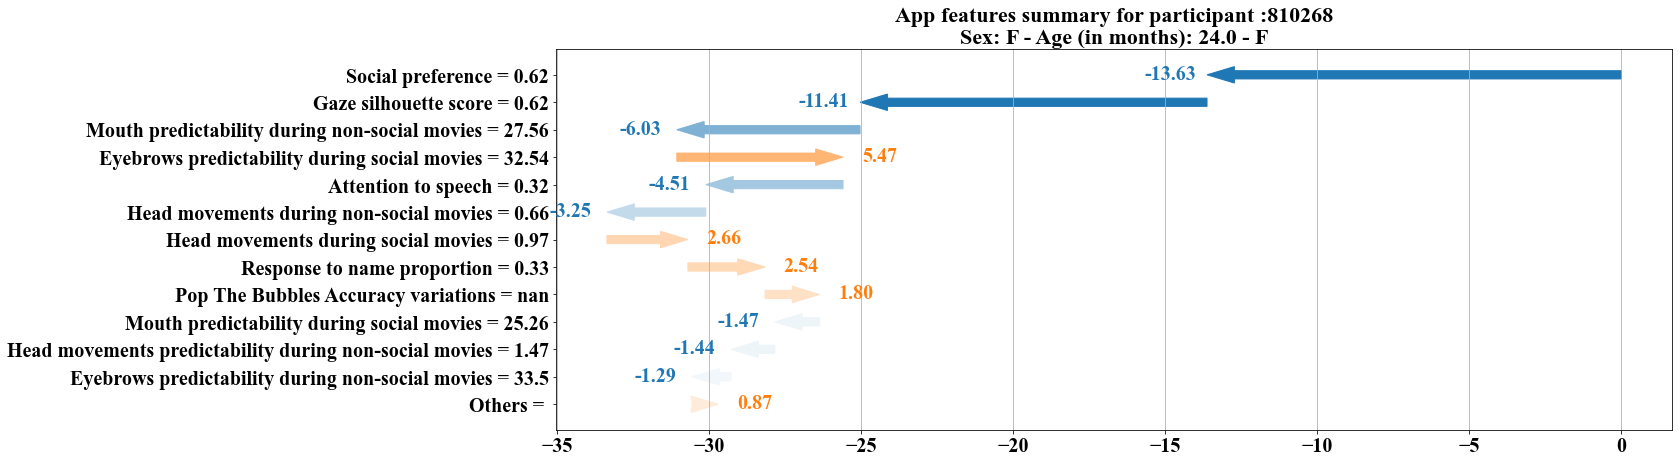

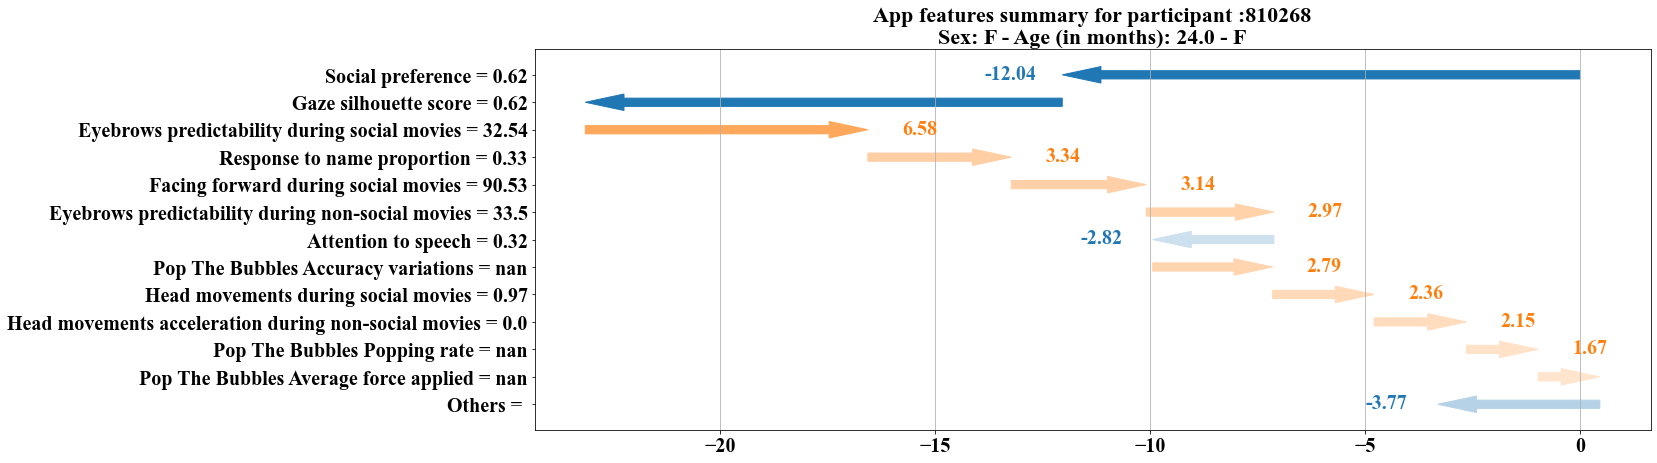

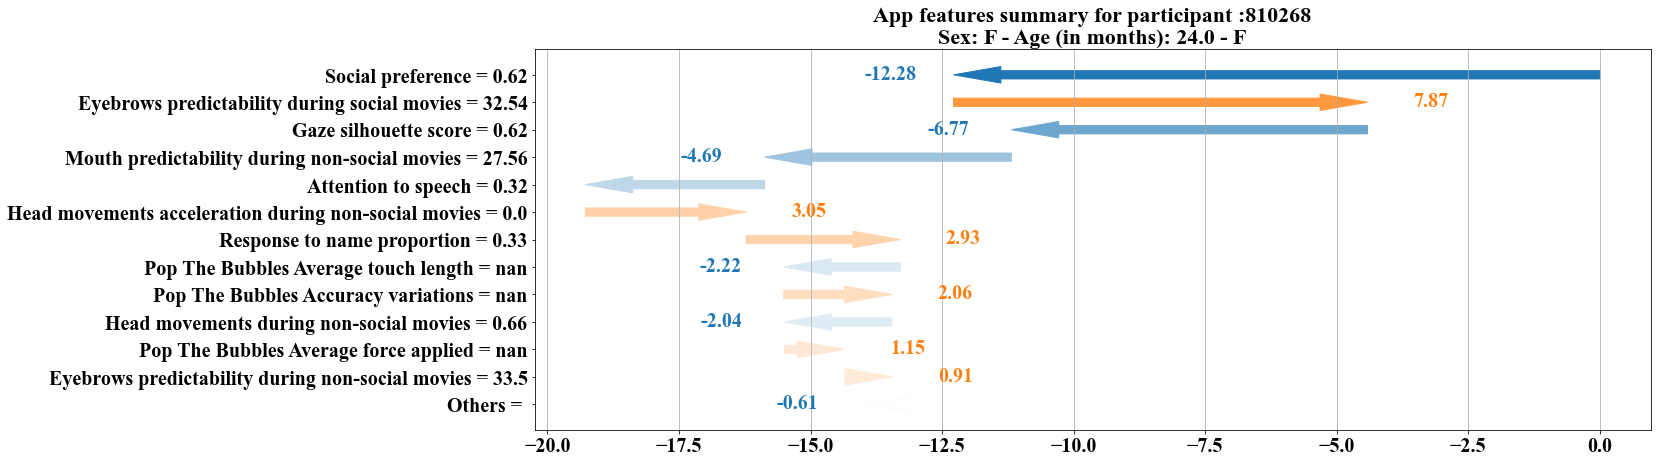

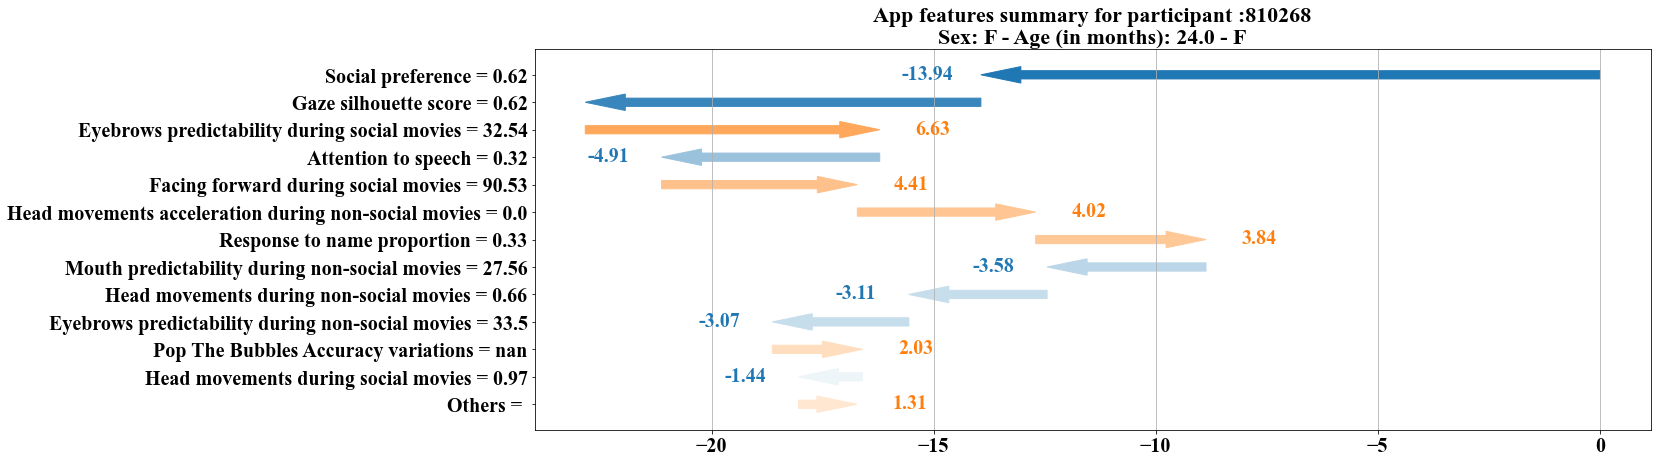

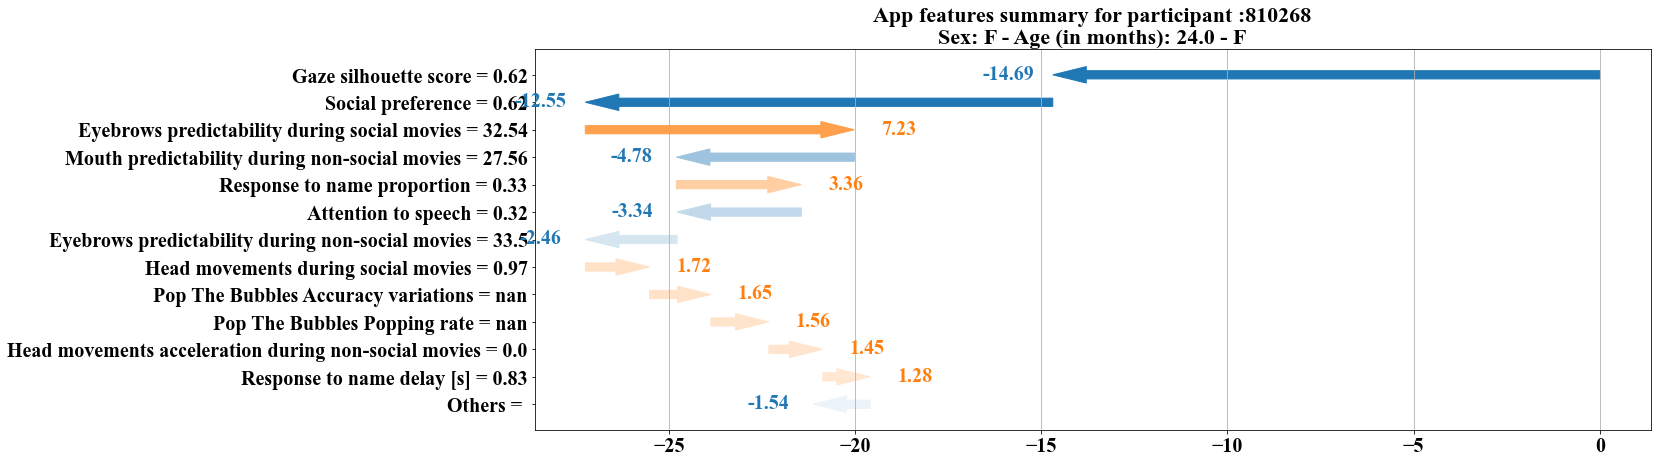

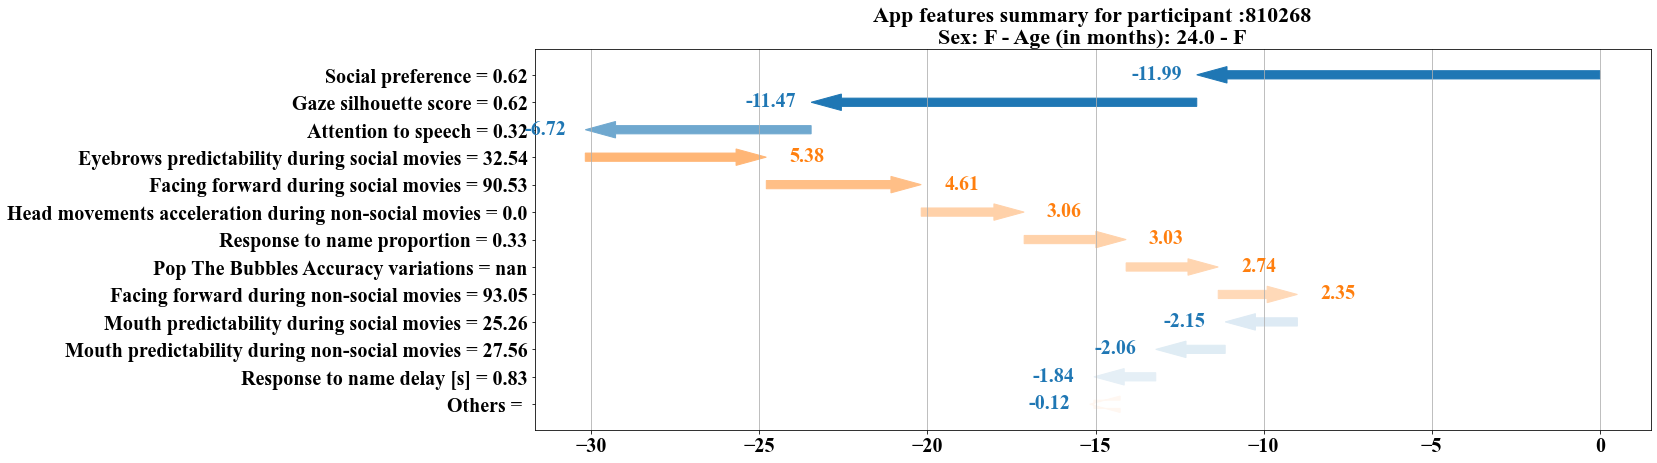

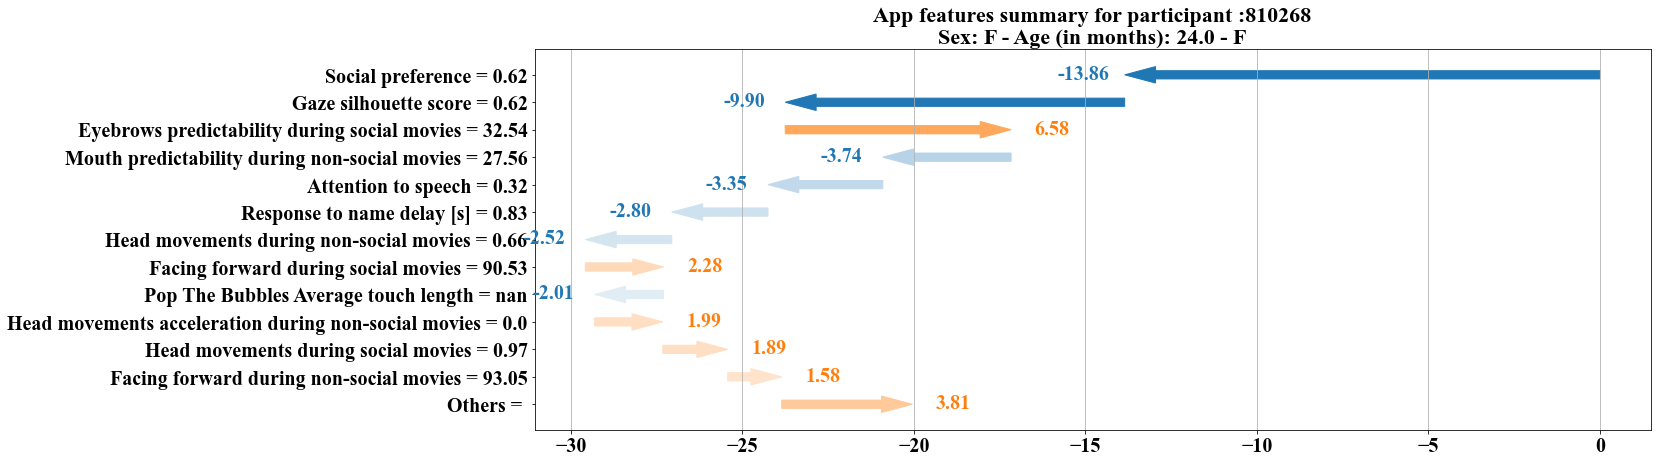

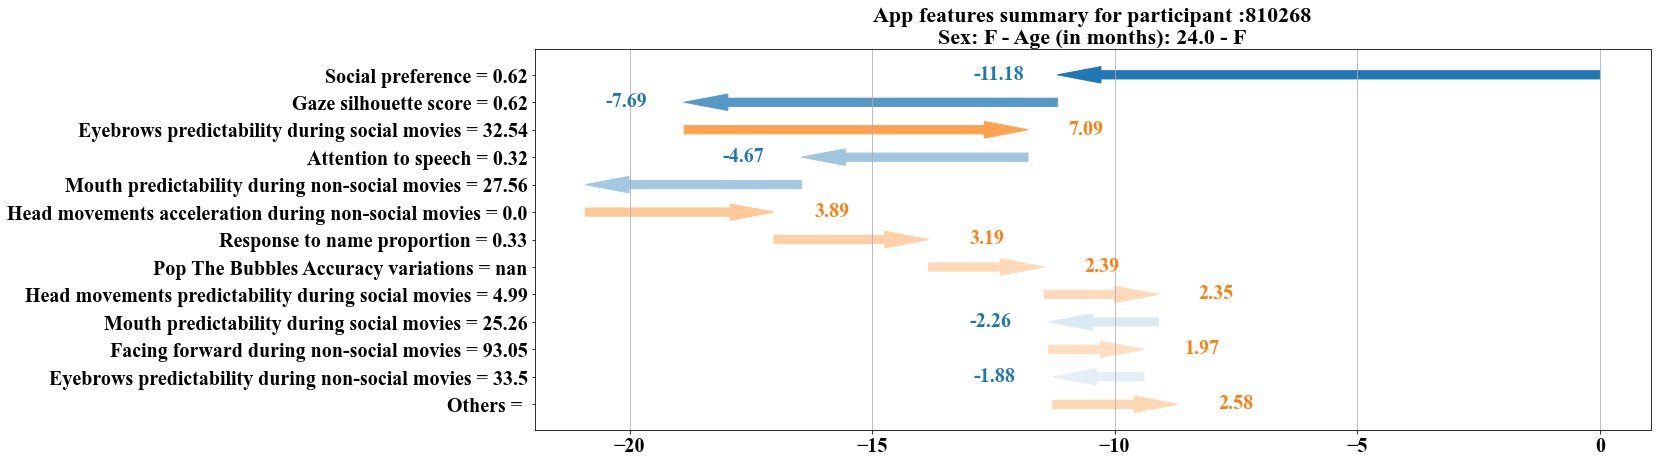

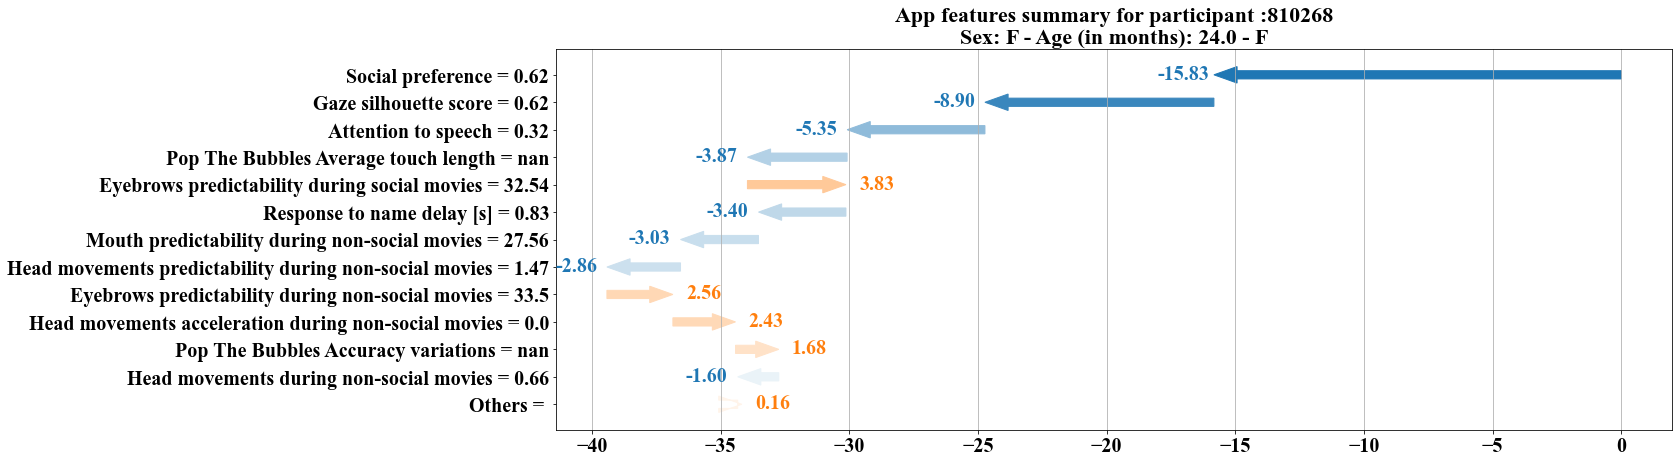

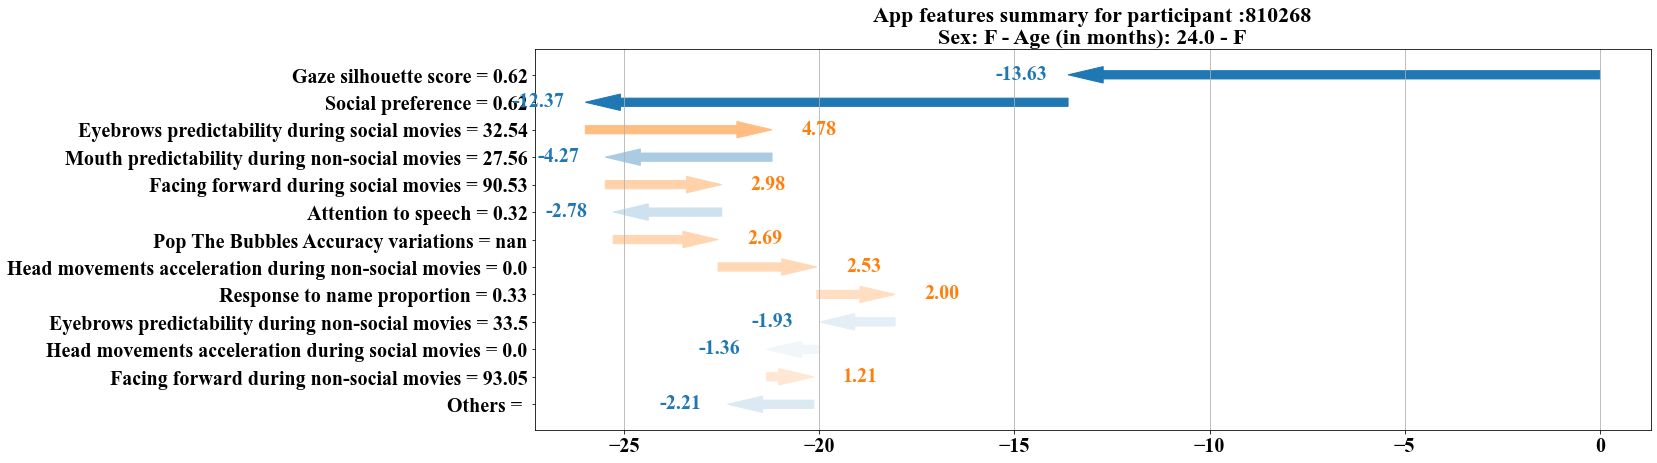

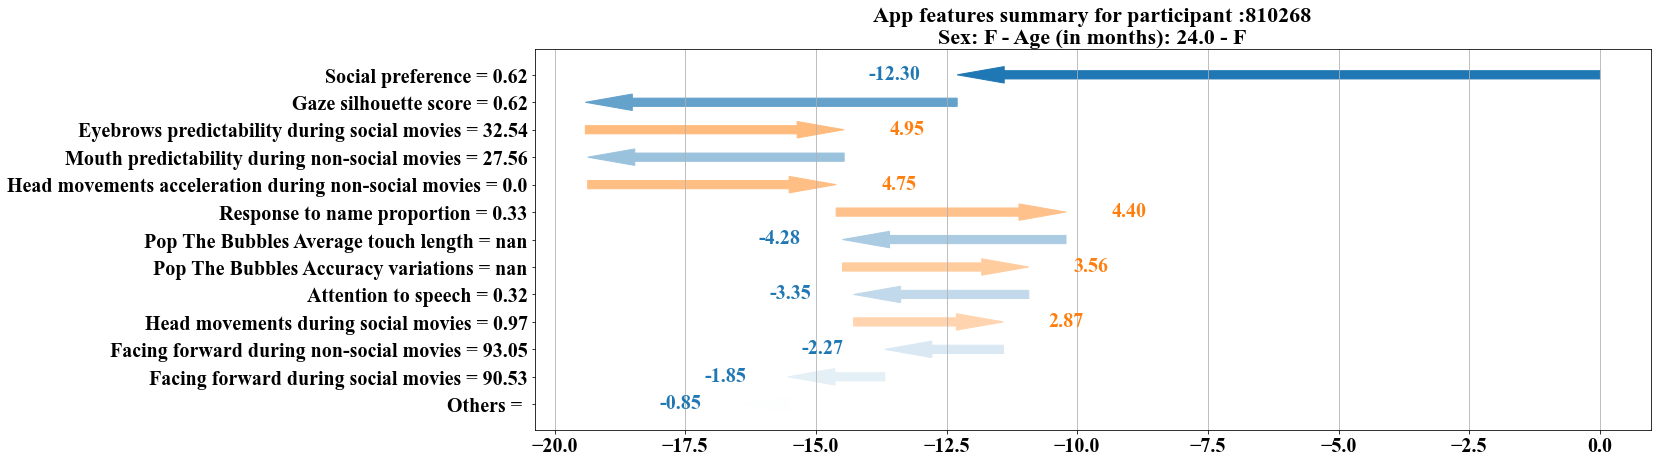

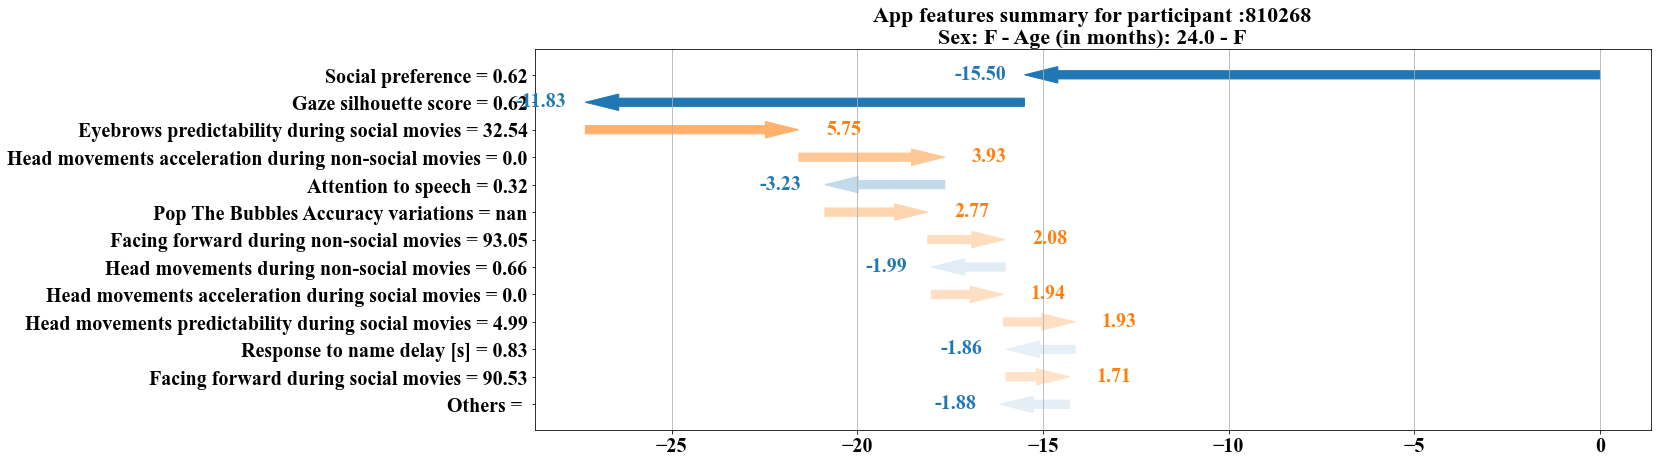

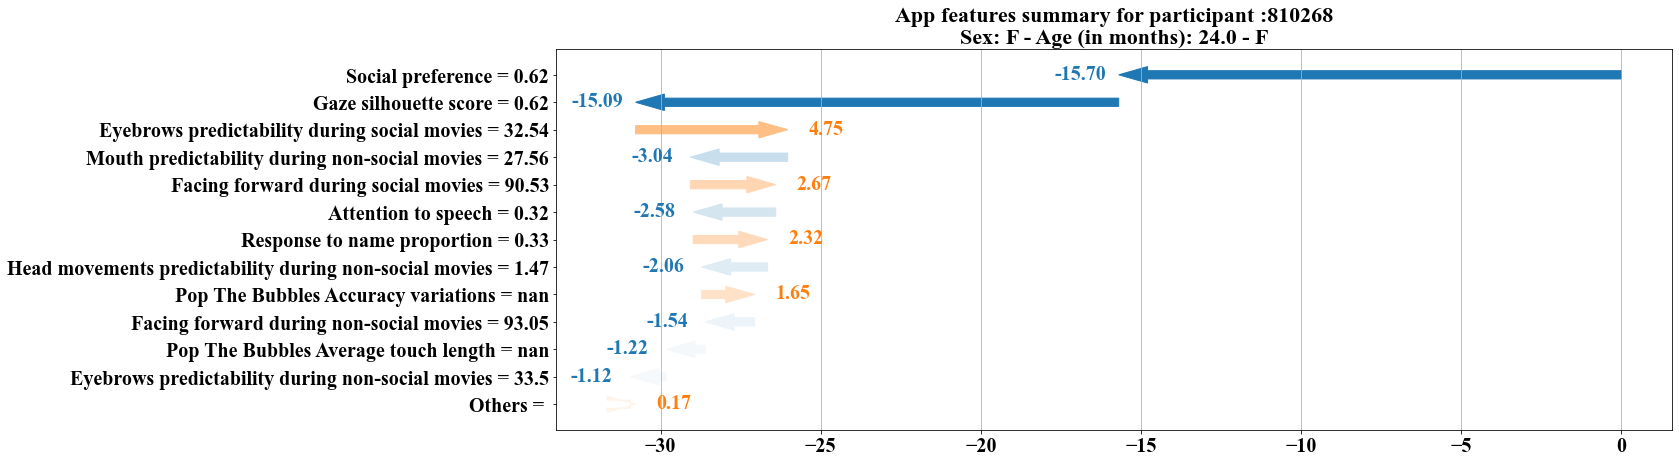

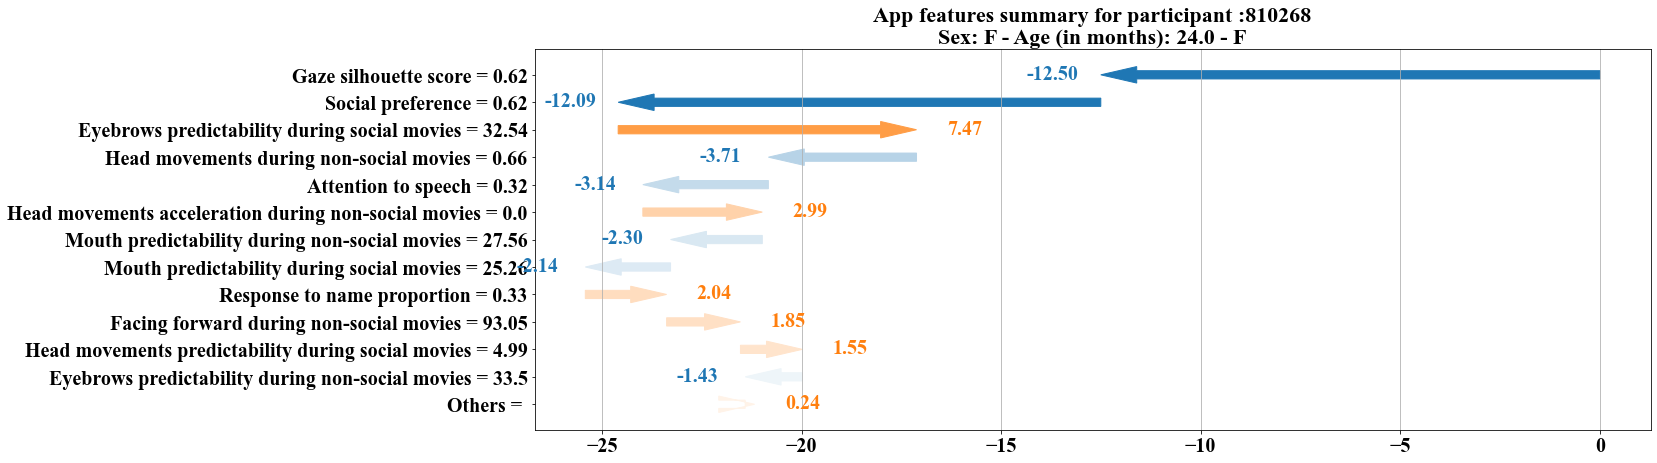

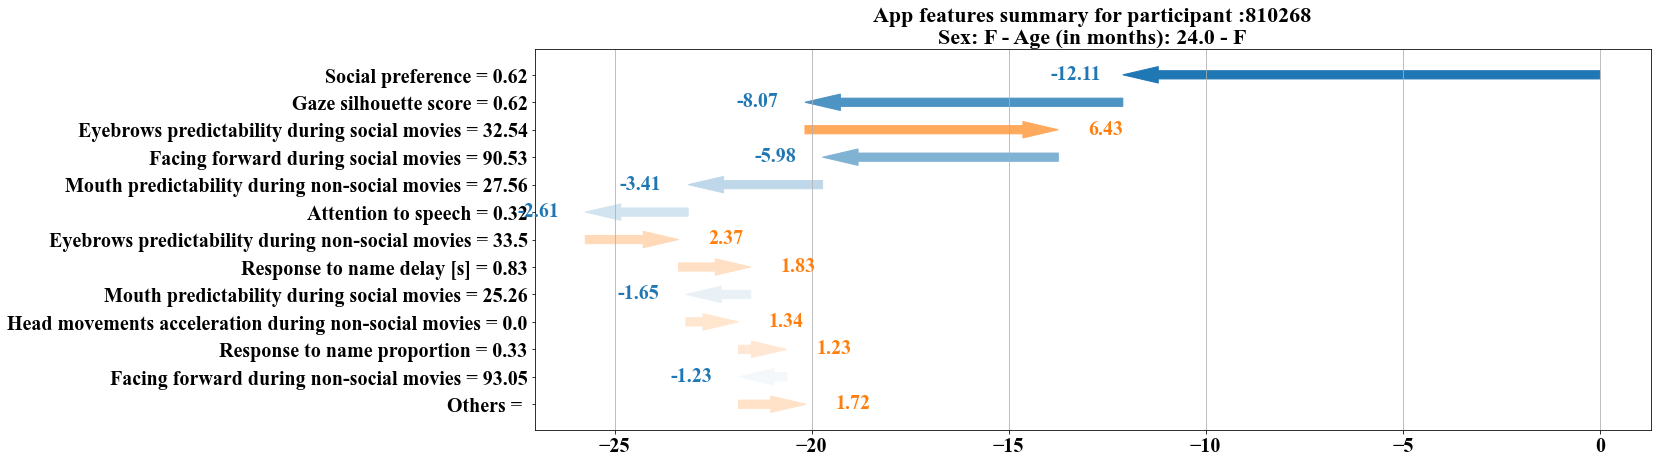

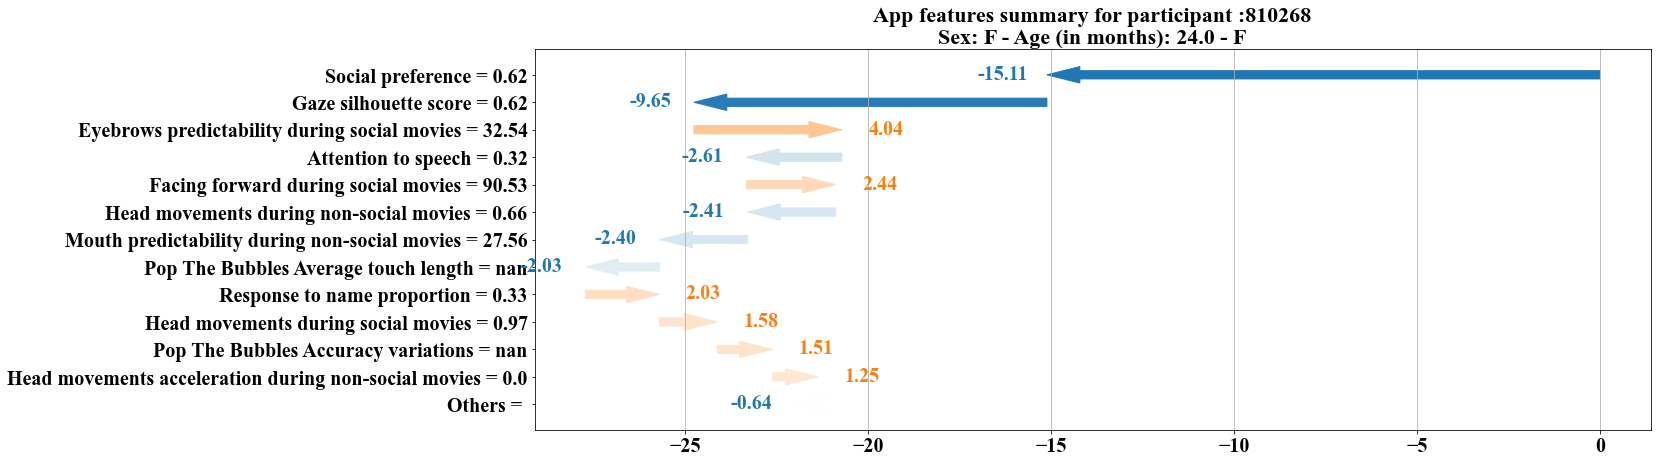

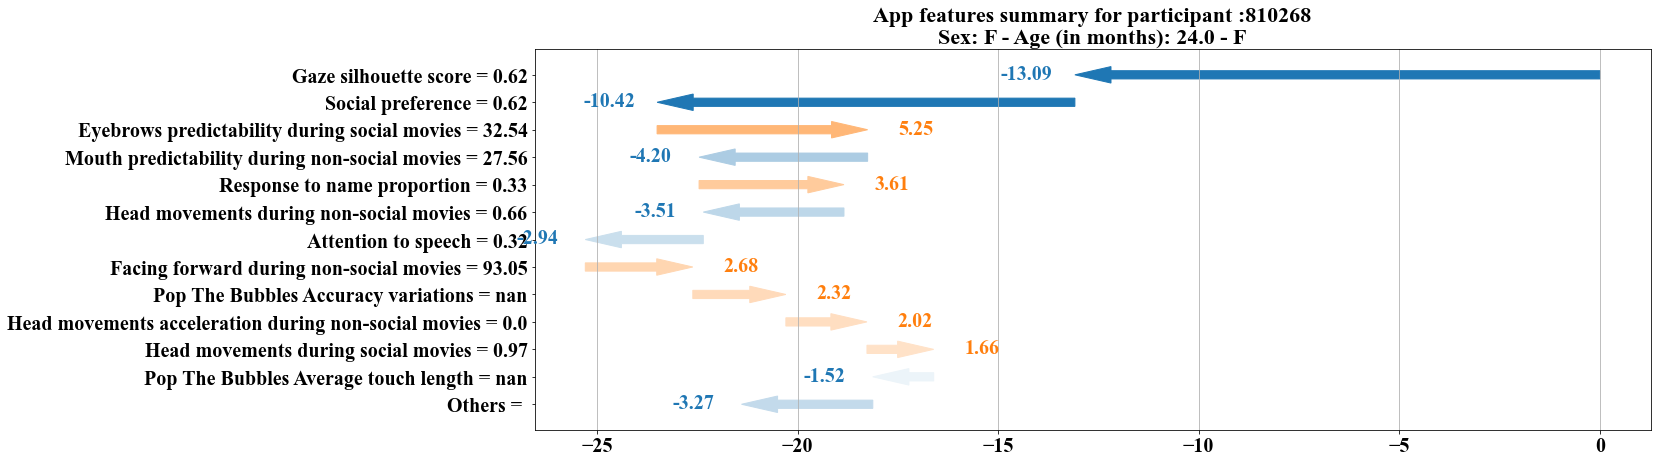

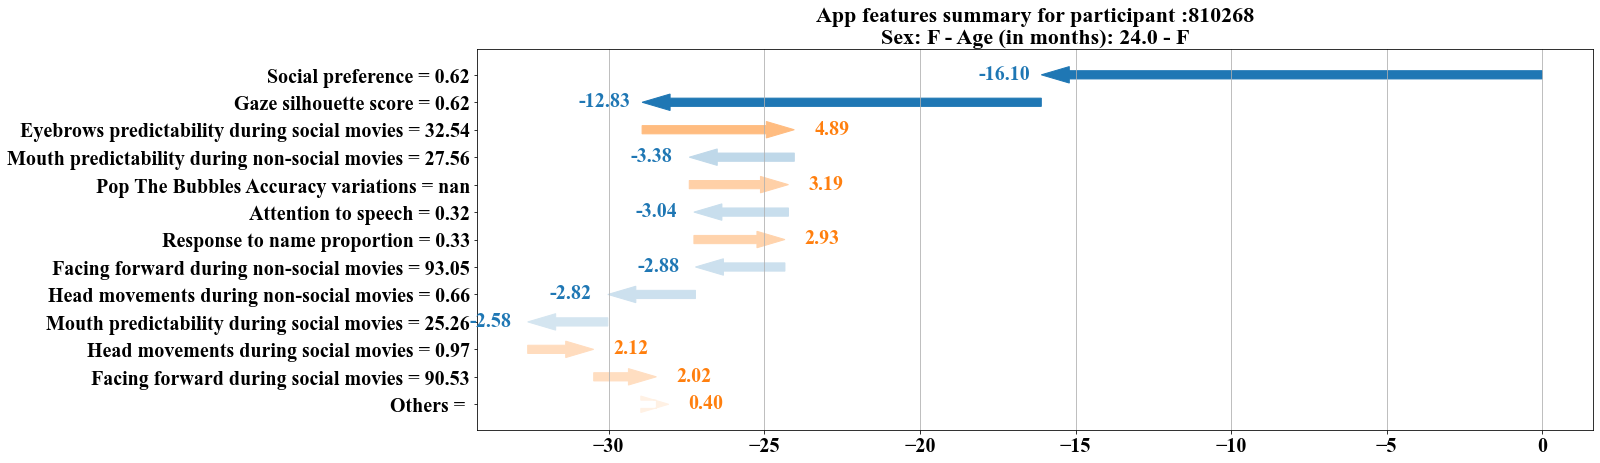

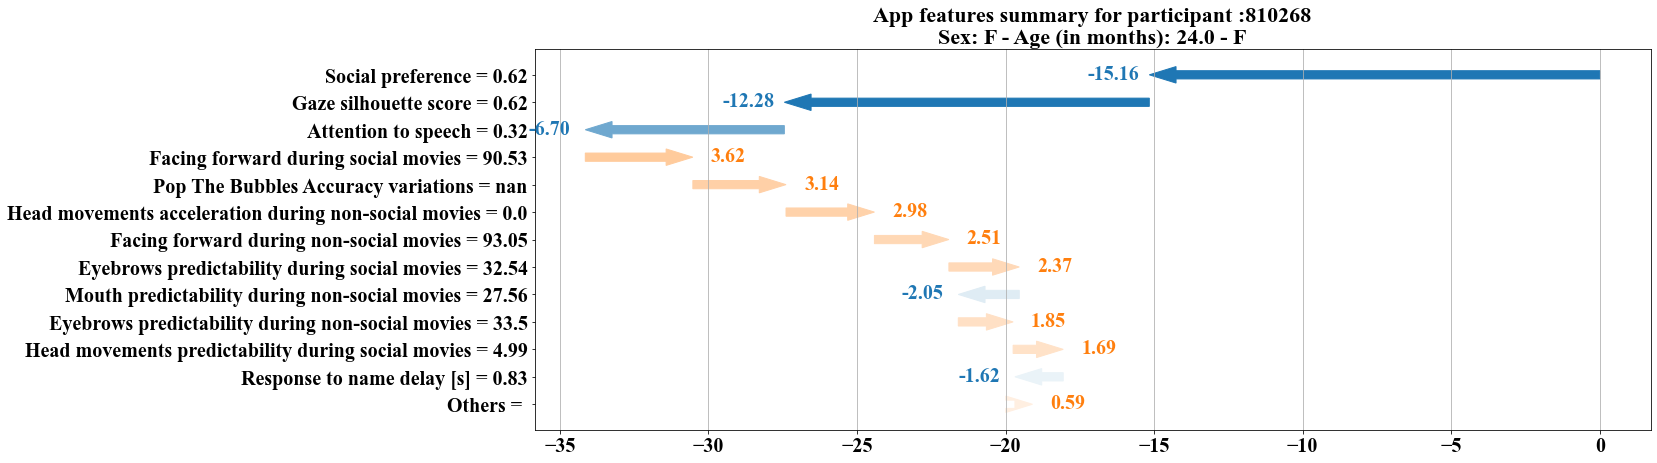

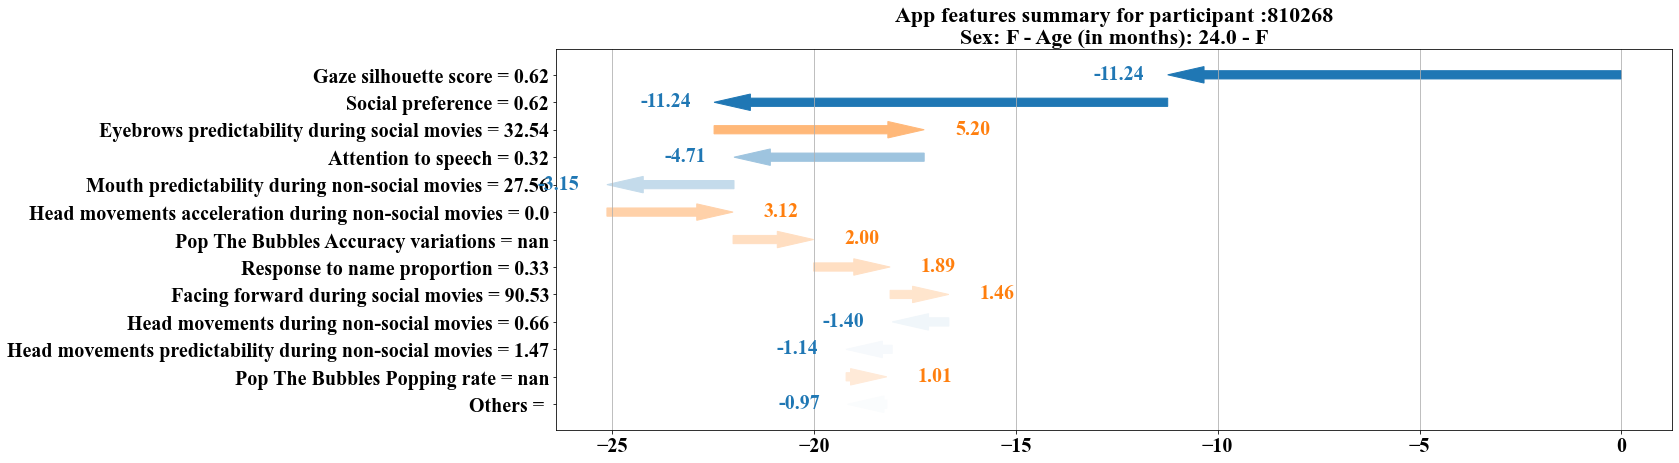

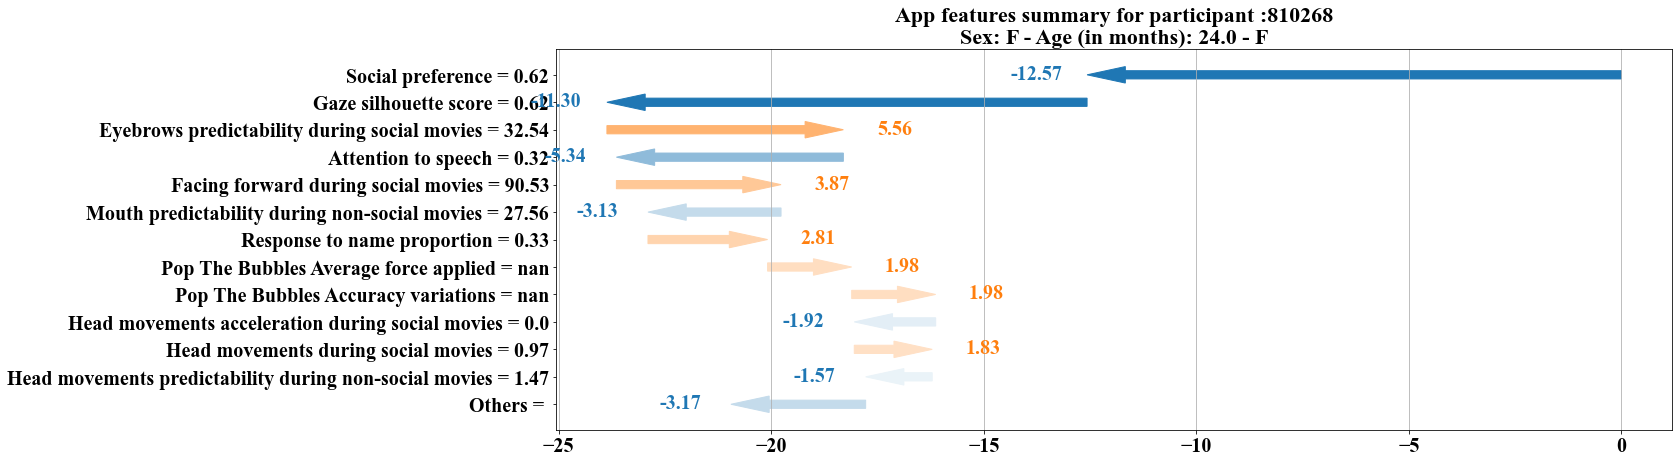

In [62]:
for i in range(25): # Draw a random smaple and plot the shap matrix
    matrix_shap = shap_interactions_normalized[i][index_sample]*100

    waterfall_plot(exp, matrix_shap, index_sample)

**Show False Positive**

In [81]:
exp.predictions_df[exp.predictions_df['pred_class']=='FN']

mean_gaze_percent_right  gaze_silhouette_score  FP_gaze_speech_correlation  proportion_of_name_call_responses  average_response_to_name_delay  S_postural_sway  NS_postural_sway  S_postural_sway_derivative  NS_postural_sway_derivative  S_postural_sway_complexity  NS_postural_sway_complexity  S_facing_forward  NS_facing_forward  S_eyebrows_complexity  NS_eyebrows_complexity  S_mouth_complexity  NS_mouth_complexity  pop_rate  std_error  average_length  average_force_applied  y_true    y_pred  TN  TP  FP  FN pred_class  conslusiveness_score
3                   0.510189               0.608424                    0.056406                           0.666667                        2.469133         1.328129          2.397114                    0.004554                     0.012627                    3.651270                     0.647567         82.993961          67.376848              28.541997               21.578304           26.958703            19.827632       NaN        NaN             NaN                    NaN     1.0  0.005182   0   0   0   1         FN                  0.02
10                  0.370476               0.513576                    0.106330                           1.000000                        0.722944         0.288321          0.278590                    0.001879                     0.001312                    8.585445                     2.887158         91.644199          92.912484              28.132391               29.459527           25.377356            25.801698       NaN        NaN             NaN                    NaN     1.0  0.000305   0   0   0   1         FN                  0.00
35                  0.452378               0.517506                    0.055674                           0.666667                        0.550550         2.171059          0.485643                    0.008712                     0.003309                    6.807071                     1.132027         80.404082          85.715025              20.855985               29.562172           19.196737            24.471573  0.533333   8.077437       12.326764               0.064923     1.0  0.030705   0   0   0   1         FN                  0.98
227                 0.561774               0.576836                    0.142624                           0.333333                        0.867533         0.376969          1.441525                    0.001139                     0.009709                    6.695202                     2.168086         94.054954          94.365692              28.029841               30.968278           27.747488            29.323335       NaN        NaN             NaN                    NaN     1.0  0.000572   0   0   0   1         FN                  0.02
272                 0.501582               0.599296                    0.461882                           0.000000                             NaN         0.562841          1.392681                    0.003384                     0.007153                    7.079523                     0.858497         96.946706          82.046443              30.720274               27.628416           25.560943            28.509753  0.750000  12.478407        6.014059               0.071955     1.0  0.000098   0   0   0   1         FN                  0.00
336                 0.607484               0.390397                    0.063776                           0.000000                             NaN         0.785228          0.550685                    0.003690                     0.003032                    8.316039                     4.073000         90.355307          95.510094              31.199868               32.216073           24.607172            24.766872  0.250000  16.662007       24.815455               0.008114     1.0  0.029866   0   0   0   1         FN                  0.14
375                 0.425809               0.551651                         NaN                           0.666667                        0.316983         0.232464      

pred_class  quality_score  conslusiveness_score
107         FP       0.949471                   1.0

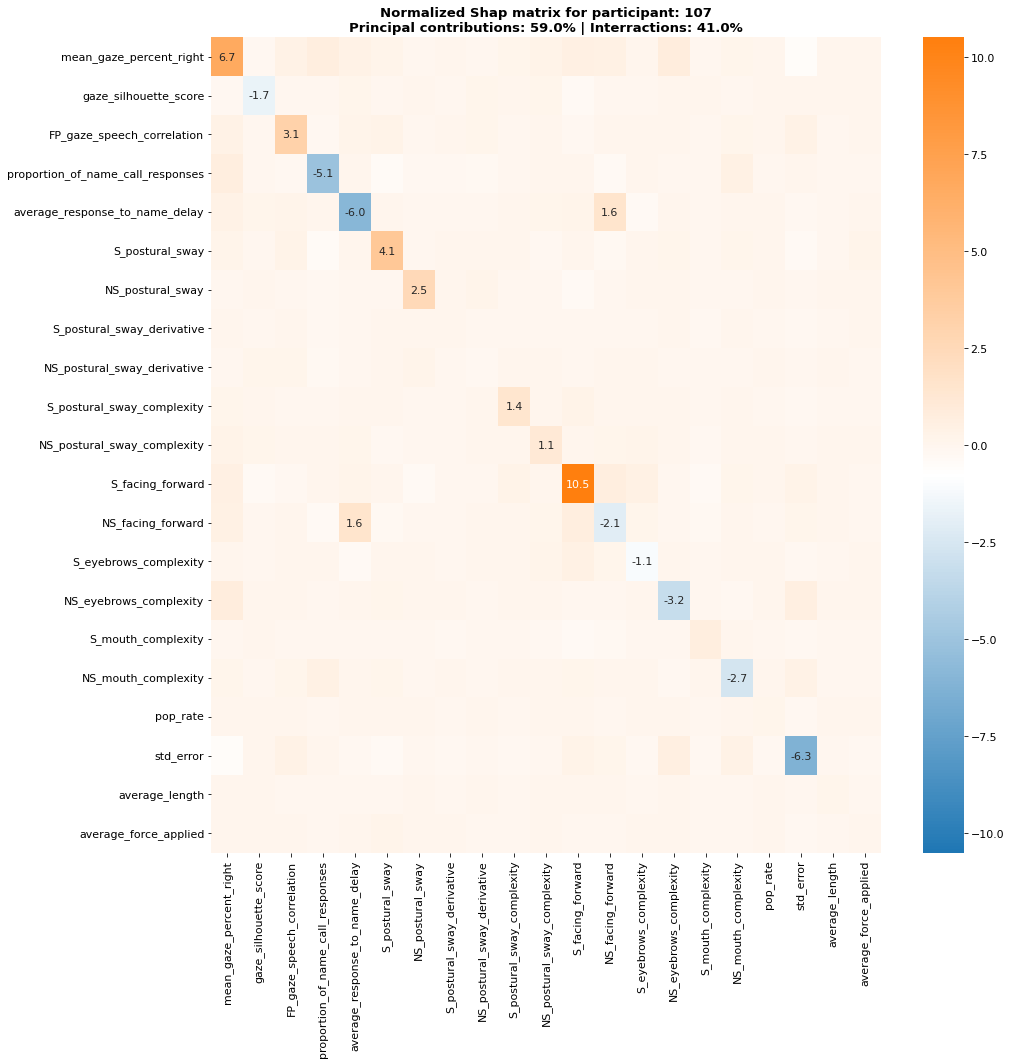

total       main interaction first_interaction             first_interaction_name
S_facing_forward                   14.414696  10.508102    3.906595          0.723714                  NS_facing_forward
mean_gaze_percent_right            11.600729   6.699751    4.900978          0.773872             NS_eyebrows_complexity
std_error                          10.088631   6.301234    3.787397            0.6559             NS_eyebrows_complexity
average_response_to_name_delay      9.205506   5.957171    3.248335           1.55004                  NS_facing_forward
proportion_of_name_call_responses   7.901264   5.145747    2.755518          0.727769            mean_gaze_percent_right
S_postural_sway                     6.288487   4.055646    2.232841          0.397821  proportion_of_name_call_responses
NS_facing_forward                   6.125968   2.103311    4.022656           1.55004     average_response_to_name_delay
NS_eyebrows_complexity              5.438939    3.22792    2.211019          0.773872            mean_gaze_percent_right
FP_gaze_speech_correlation          5.194258   3.135366    2.058892          0.387339                          std_error
NS_mouth_complexity                 4.445975   2.705826     1.74015          0.422854  proportion_of_name_call_responses
NS_postural_sway                      3.6218   2.530478    1.091322          0.284689                   S_facing_forward
gaze_silhouette_score               2.922345   1.720889    1.201455          0.277813                   S_facing_forward
S_eyebrows_complexity                2.53629   1.108873    1.427417          0.415581                   S_facing_forward
NS_postural_sway_complexity         2.458438     1.1194    1.339038          0.266978            mean_gaze_percent_right
S_postural_sway_complexity          2.309871   1.422476    0.887396           0.25207                   S_facing_forward
S_mouth_complexity                  2.020256   0.722425    1.297831          0.267056                   S_facing_forward
S_postural_sway_derivative          0.952349   0.072661    0.879688          0.157412                          std_error
NS_postural_sway_derivative         0.926435    0.14712    0.779315          0.208581                   NS_postural_sway
average_force_applied               0.611468   0.073181    0.538287          0.166082                    S_postural_sway
pop_rate                            0.573437   0.113566    0.459871          0.147845                          std_error
average_length                      0.362859   0.133662    0.229197          0.041931            mean_gaze_percent_right
SUM                                      100  59.004805   40.995195

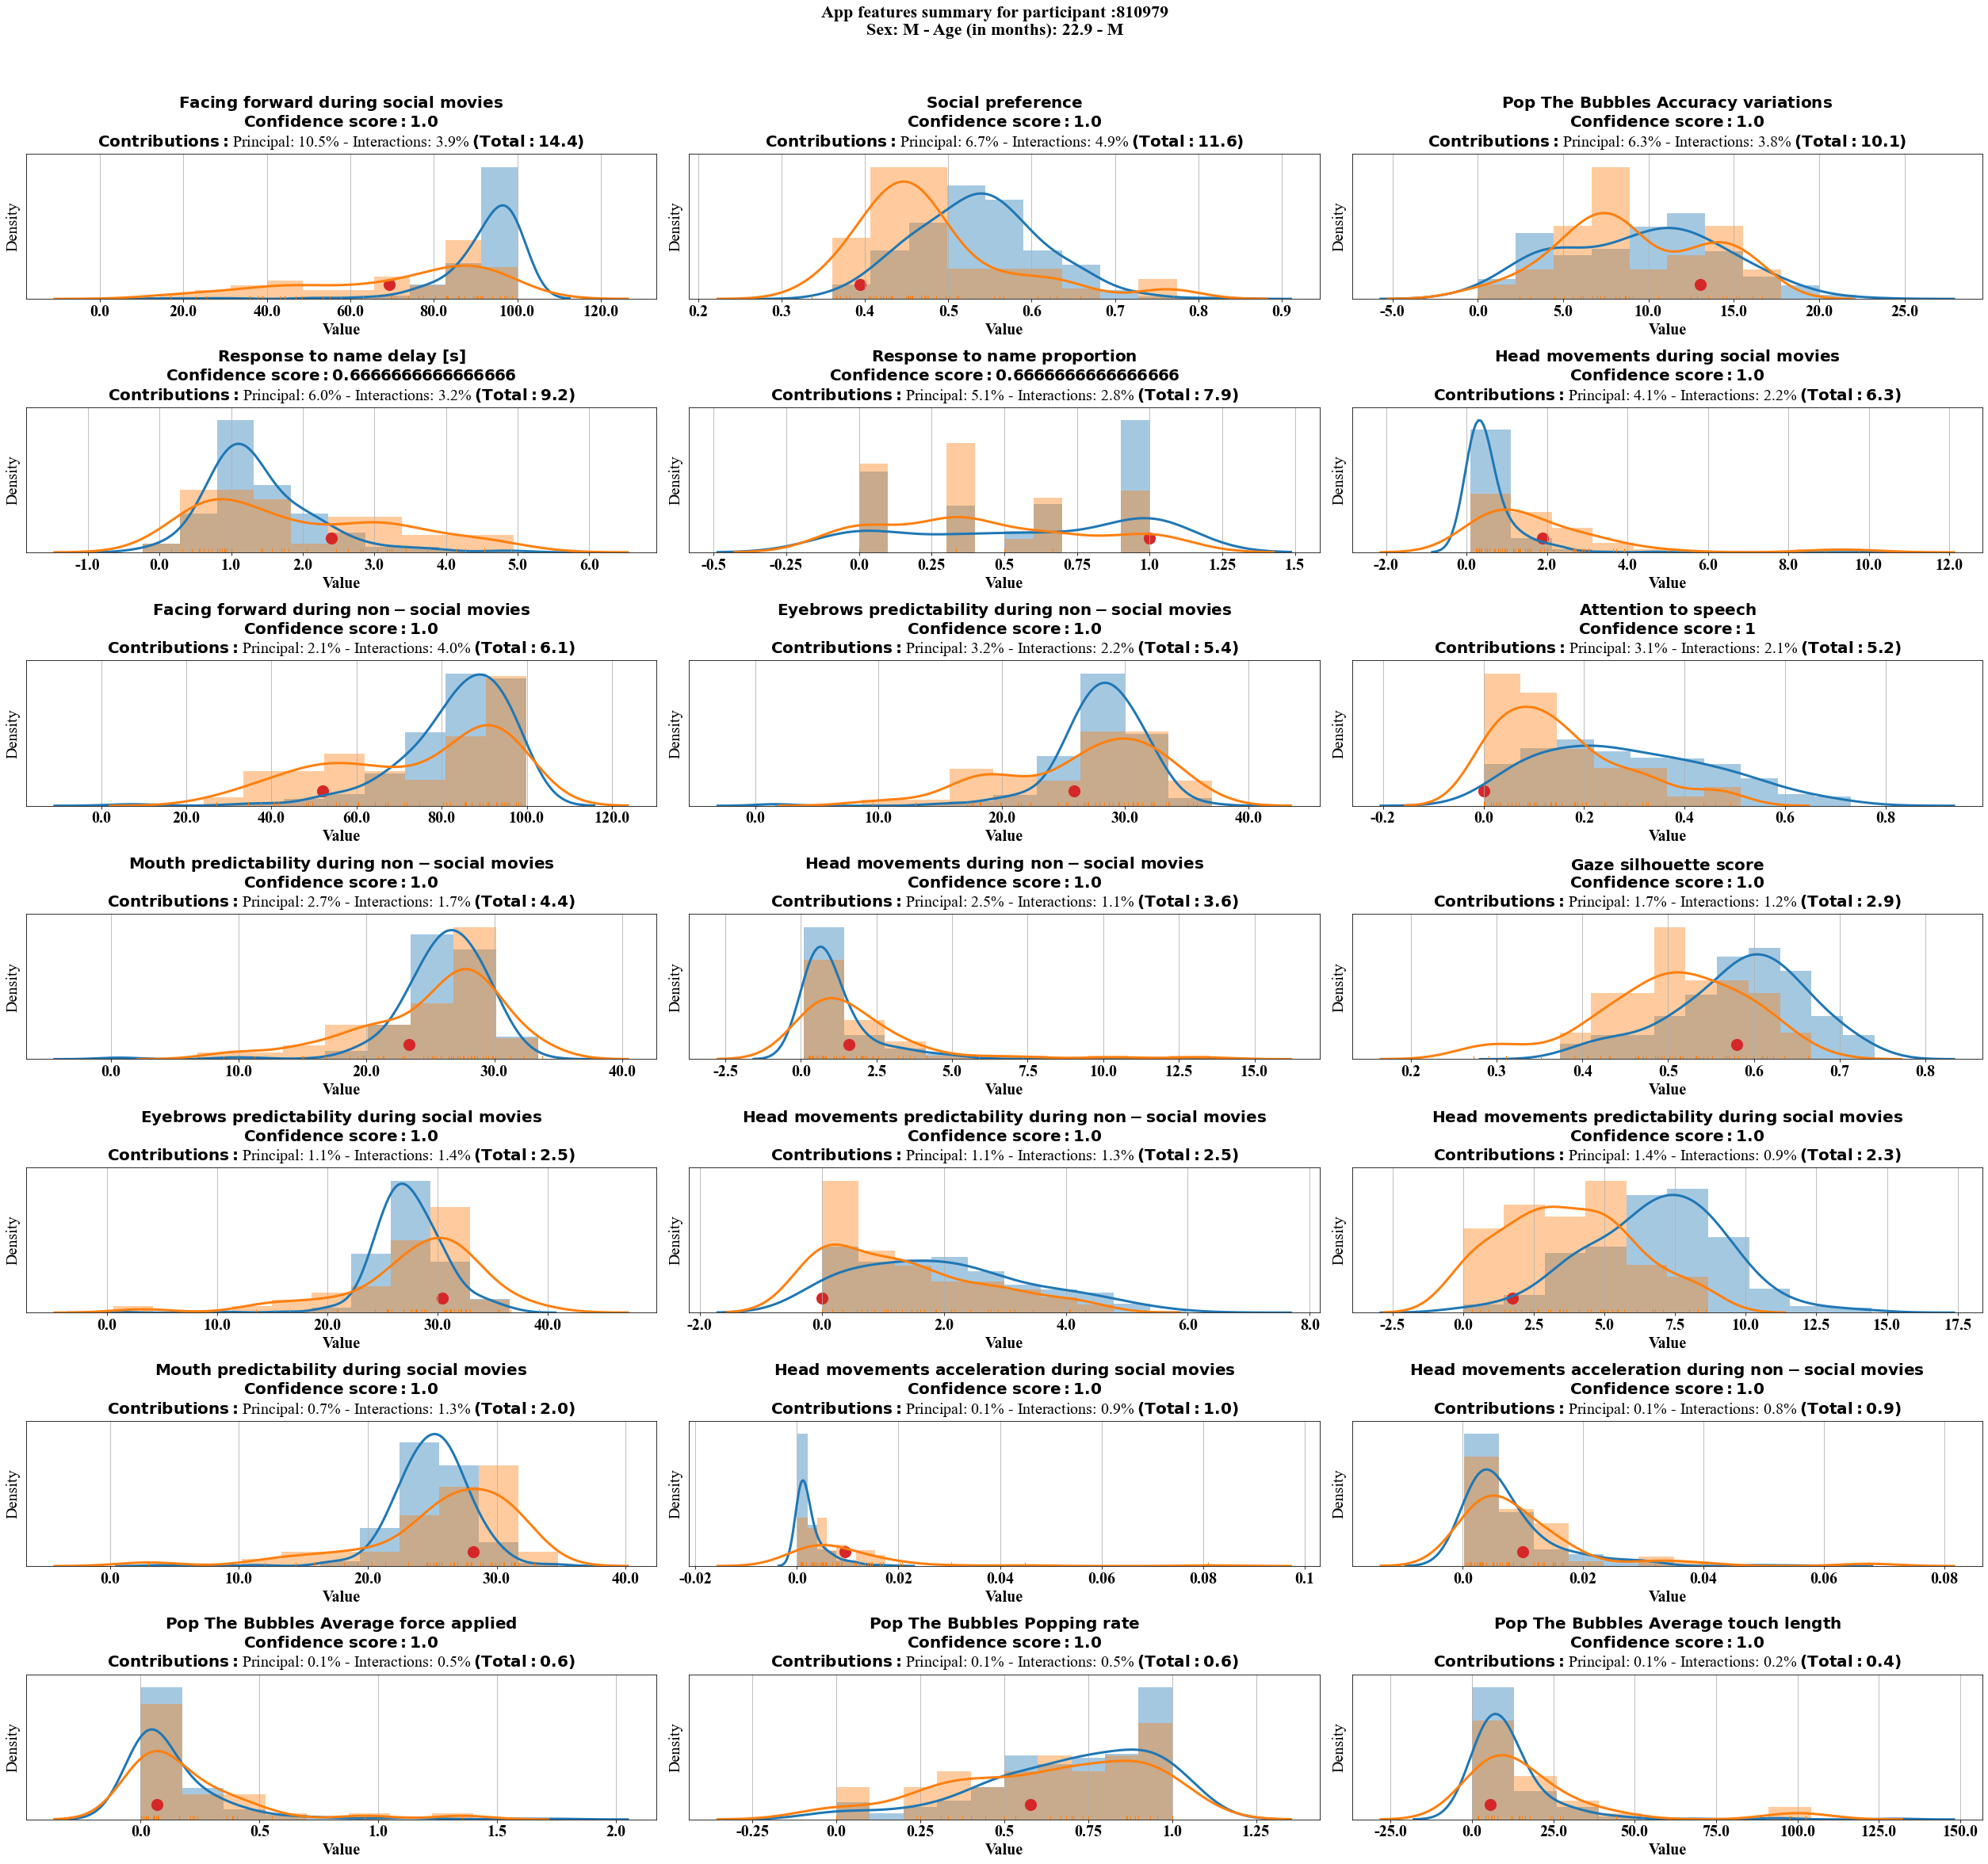

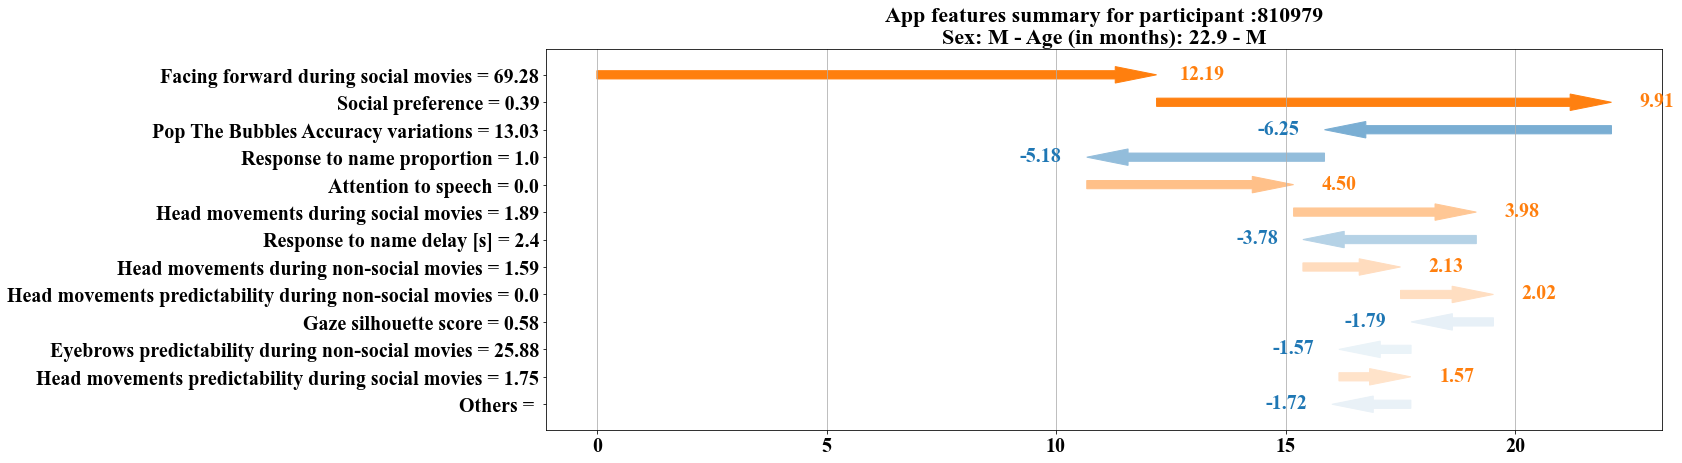

Facing forward during social movies: 1.00
Social preference: 1.00
Pop The Bubbles Accuracy variations: 1.00
Response to name proportion: 0.67
Attention to speech: 1.00
Head movements during social movies: 1.00
Response to name delay [s]: 0.67
Head movements during non-social movies: 1.00
Head movements predictability during non-social movies: 1.00
Gaze silhouette score: 1.00
Eyebrows predictability during non-social movies: 1.00
Head movements predictability during social movies: 1.00



In [94]:
# FP with conclusiveness score of 1
index_sample = 107
display(exp.predictions_df.iloc[index_sample:index_sample+1][['pred_class', 'quality_score', 'conslusiveness_score']])

report_participant(exp, index_sample)

pred_class  quality_score  conslusiveness_score
272         FN       0.915329                   0.0

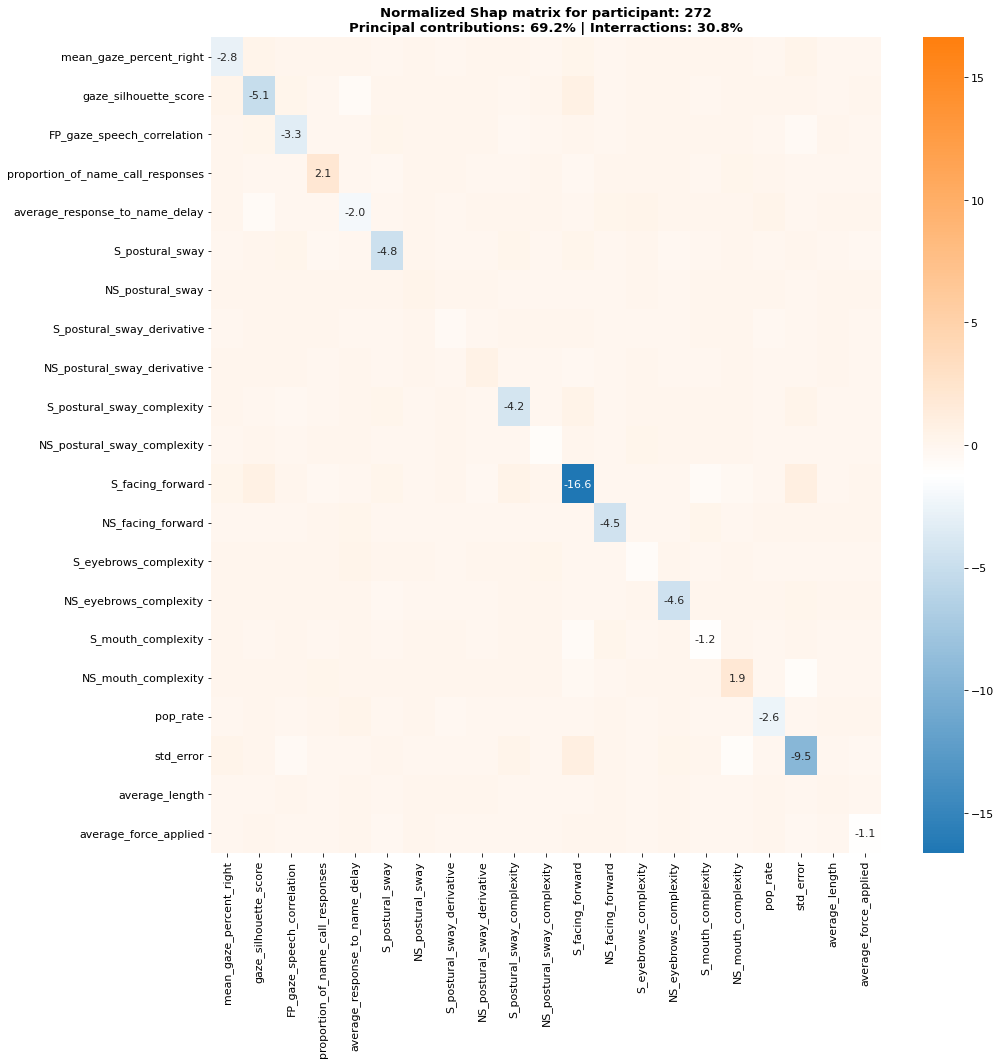

total       main interaction first_interaction             first_interaction_name
S_facing_forward                   21.036272  16.628701    4.407571          0.976676                          std_error
std_error                          13.377712   9.480468    3.897244          0.976676                   S_facing_forward
gaze_silhouette_score                7.39209   5.119749    2.272341          0.716378                   S_facing_forward
S_postural_sway                     6.618379   4.773151    1.845229          0.222858              average_force_applied
NS_facing_forward                    5.89163   4.543385    1.348245          0.217404     average_response_to_name_delay
S_postural_sway_complexity          5.832133   4.161841    1.670292          0.432072                   S_facing_forward
NS_eyebrows_complexity              5.580136   4.620837    0.959299          0.214152                          std_error
FP_gaze_speech_correlation           4.77709   3.342454    1.434636          0.453182                          std_error
mean_gaze_percent_right             4.469158   2.808219    1.660938          0.388105                          std_error
average_response_to_name_delay      4.237176   1.986091    2.251085           0.61909              gaze_silhouette_score
pop_rate                            3.728367   2.587897    1.140469          0.381221     average_response_to_name_delay
NS_mouth_complexity                 3.676261   1.855891     1.82037          0.827194                          std_error
proportion_of_name_call_responses   3.365302    2.05243    1.312872          0.216218                    S_postural_sway
S_mouth_complexity                  2.196122   1.163014    1.033108          0.635202                   S_facing_forward
average_force_applied               1.921656   1.135577    0.786079          0.222858                    S_postural_sway
S_eyebrows_complexity               1.670076   0.691162    0.978914          0.290127     average_response_to_name_delay
NS_postural_sway_complexity         1.262533   0.846852    0.415681          0.134769              S_eyebrows_complexity
NS_postural_sway_derivative         1.119241   0.536174    0.583068          0.198656                   S_facing_forward
S_postural_sway_derivative          0.926772   0.492553    0.434219          0.143543                           pop_rate
NS_postural_sway                    0.736625   0.316052    0.420574          0.073308  proportion_of_name_call_responses
average_length                      0.185269   0.035477    0.149792           0.02933            mean_gaze_percent_right
SUM                                      100  69.177974   30.822026

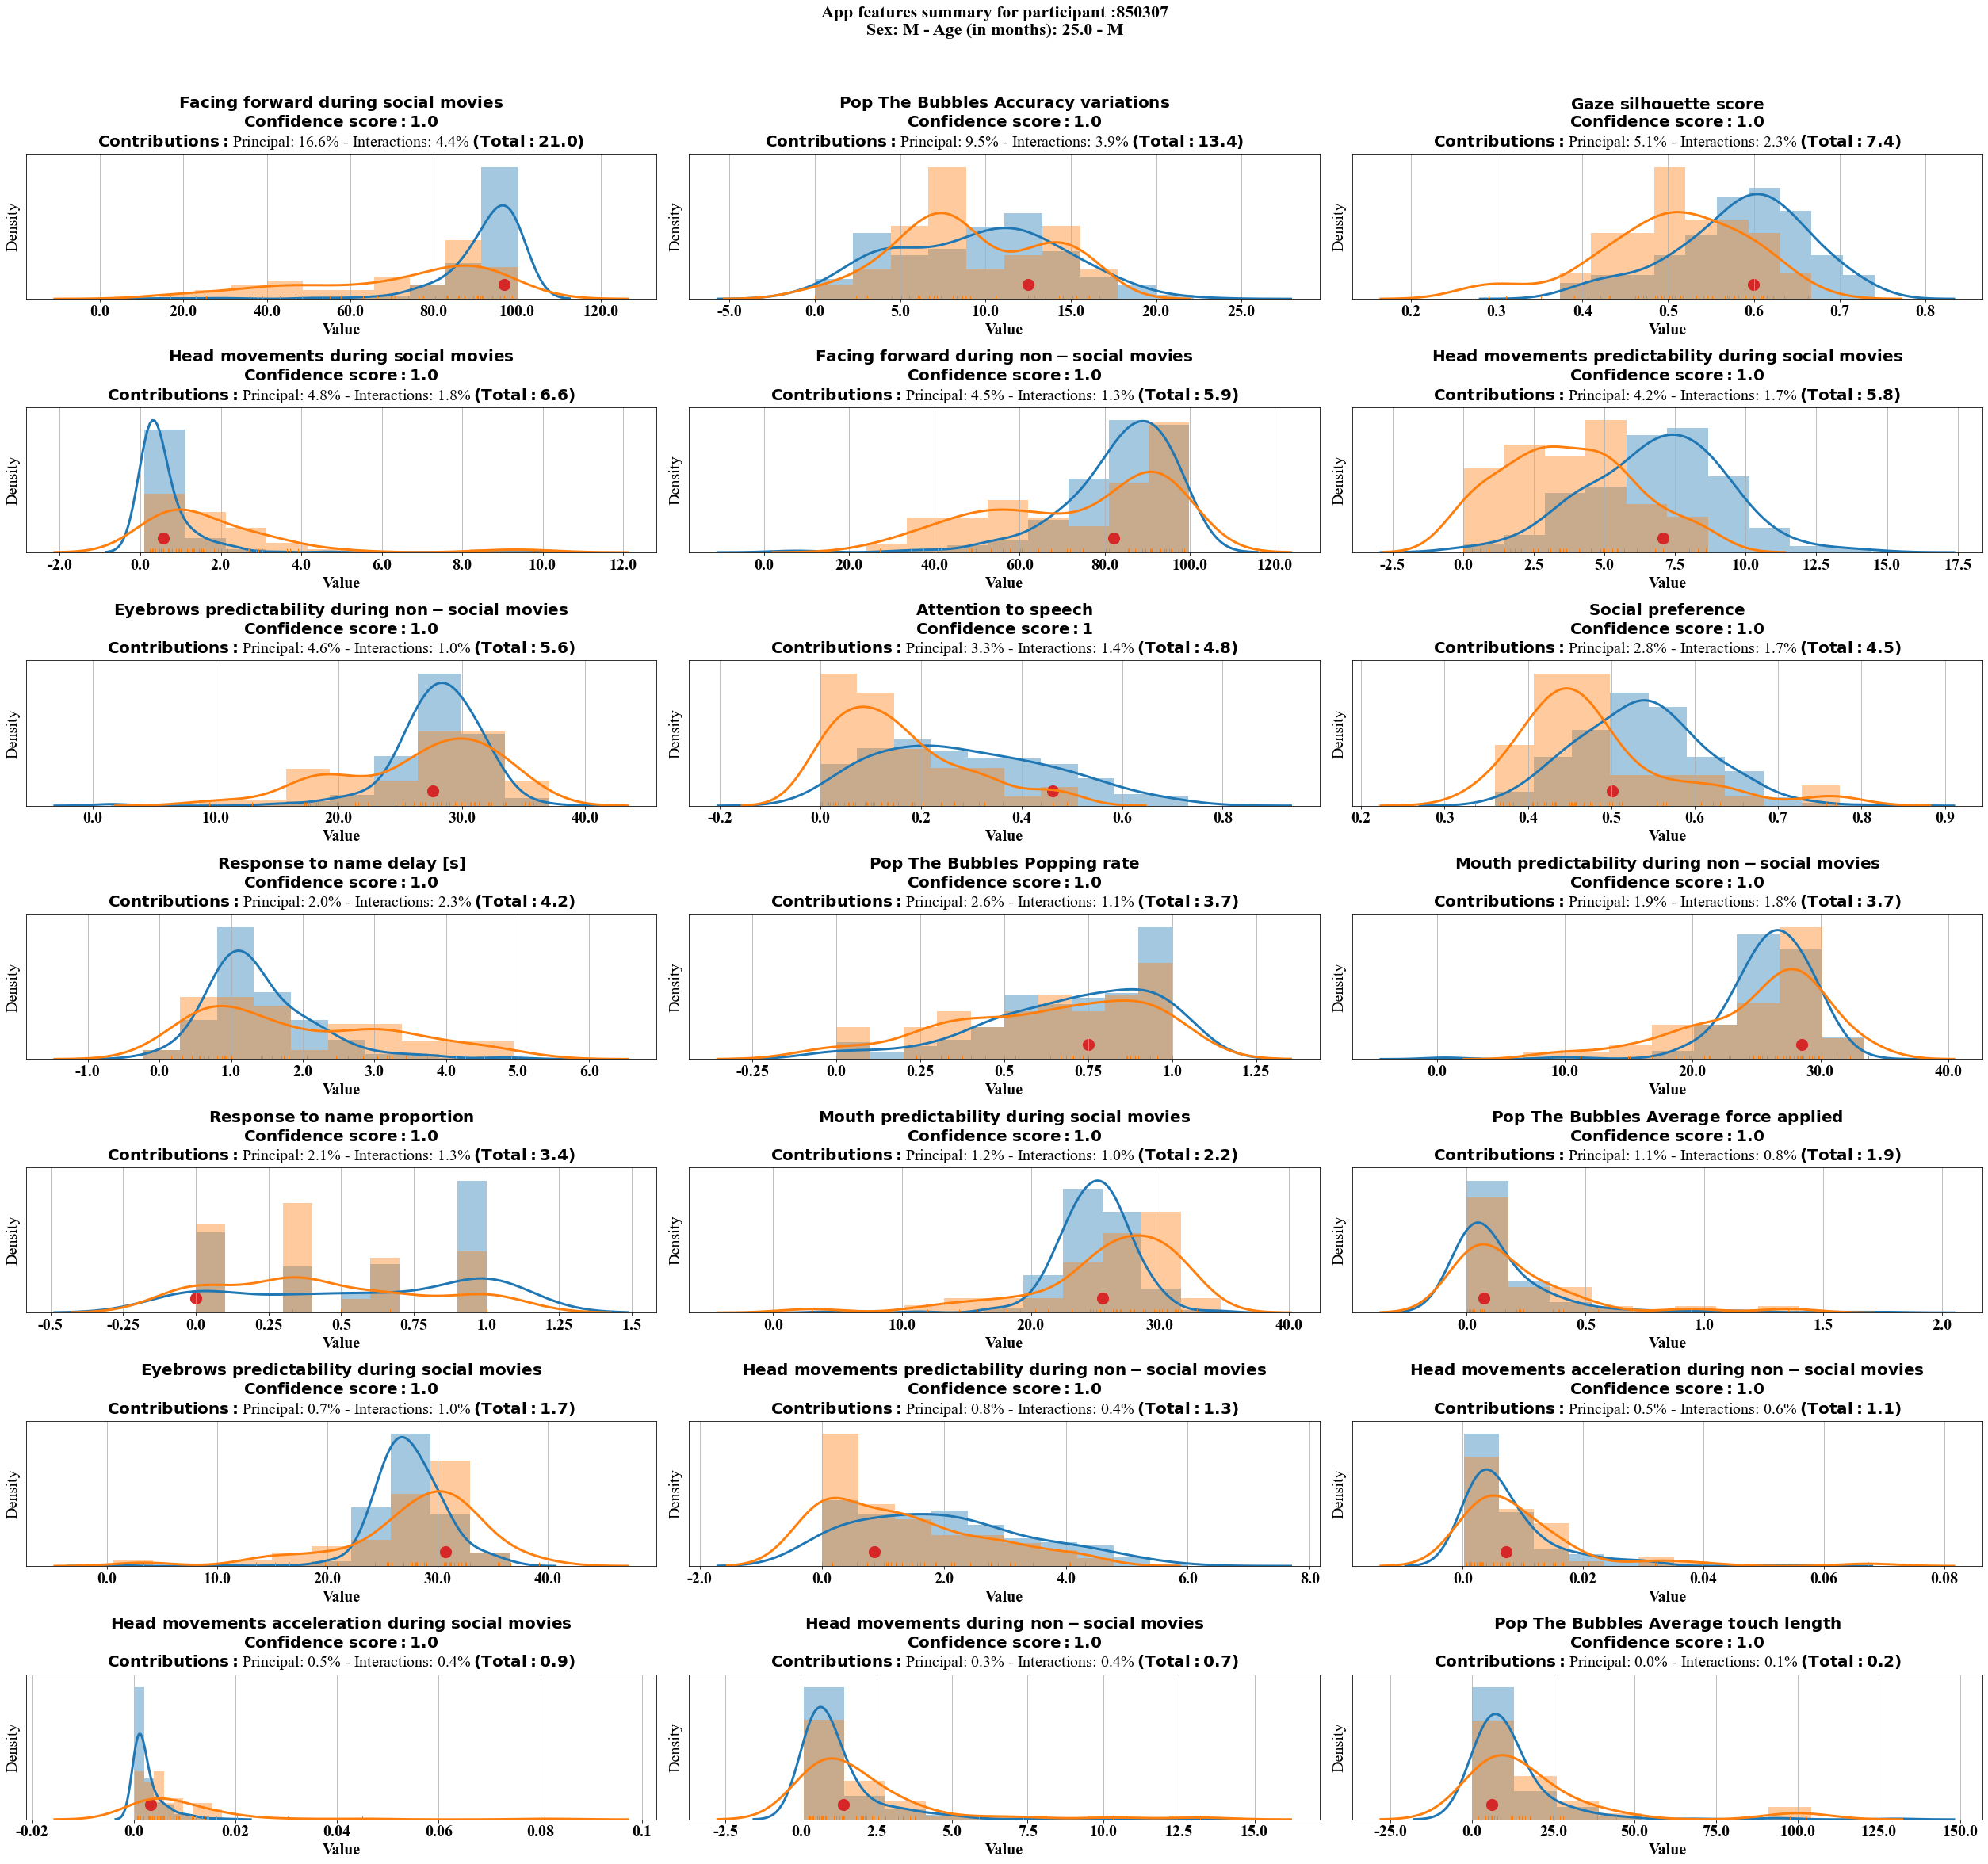

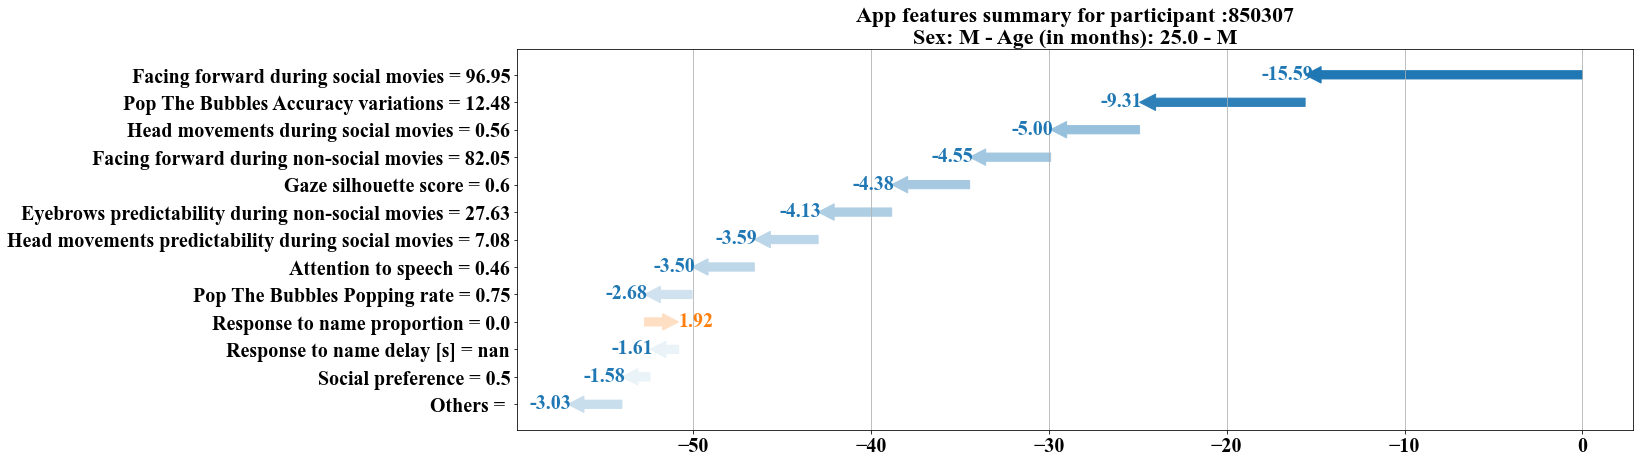

Facing forward during social movies: 1.00
Pop The Bubbles Accuracy variations: 1.00
Head movements during social movies: 1.00
Facing forward during non-social movies: 1.00
Gaze silhouette score: 1.00
Eyebrows predictability during non-social movies: 1.00
Head movements predictability during social movies: 1.00
Attention to speech: 1.00
Pop The Bubbles Popping rate: 1.00
Response to name proportion: 1.00
Response to name delay [s]: 1.00
Social preference: 1.00



In [95]:
# FP with conclusiveness score of 1
index_sample = 272
display(exp.predictions_df.iloc[index_sample:index_sample+1][['pred_class', 'quality_score', 'conslusiveness_score']])

report_participant(exp, index_sample)

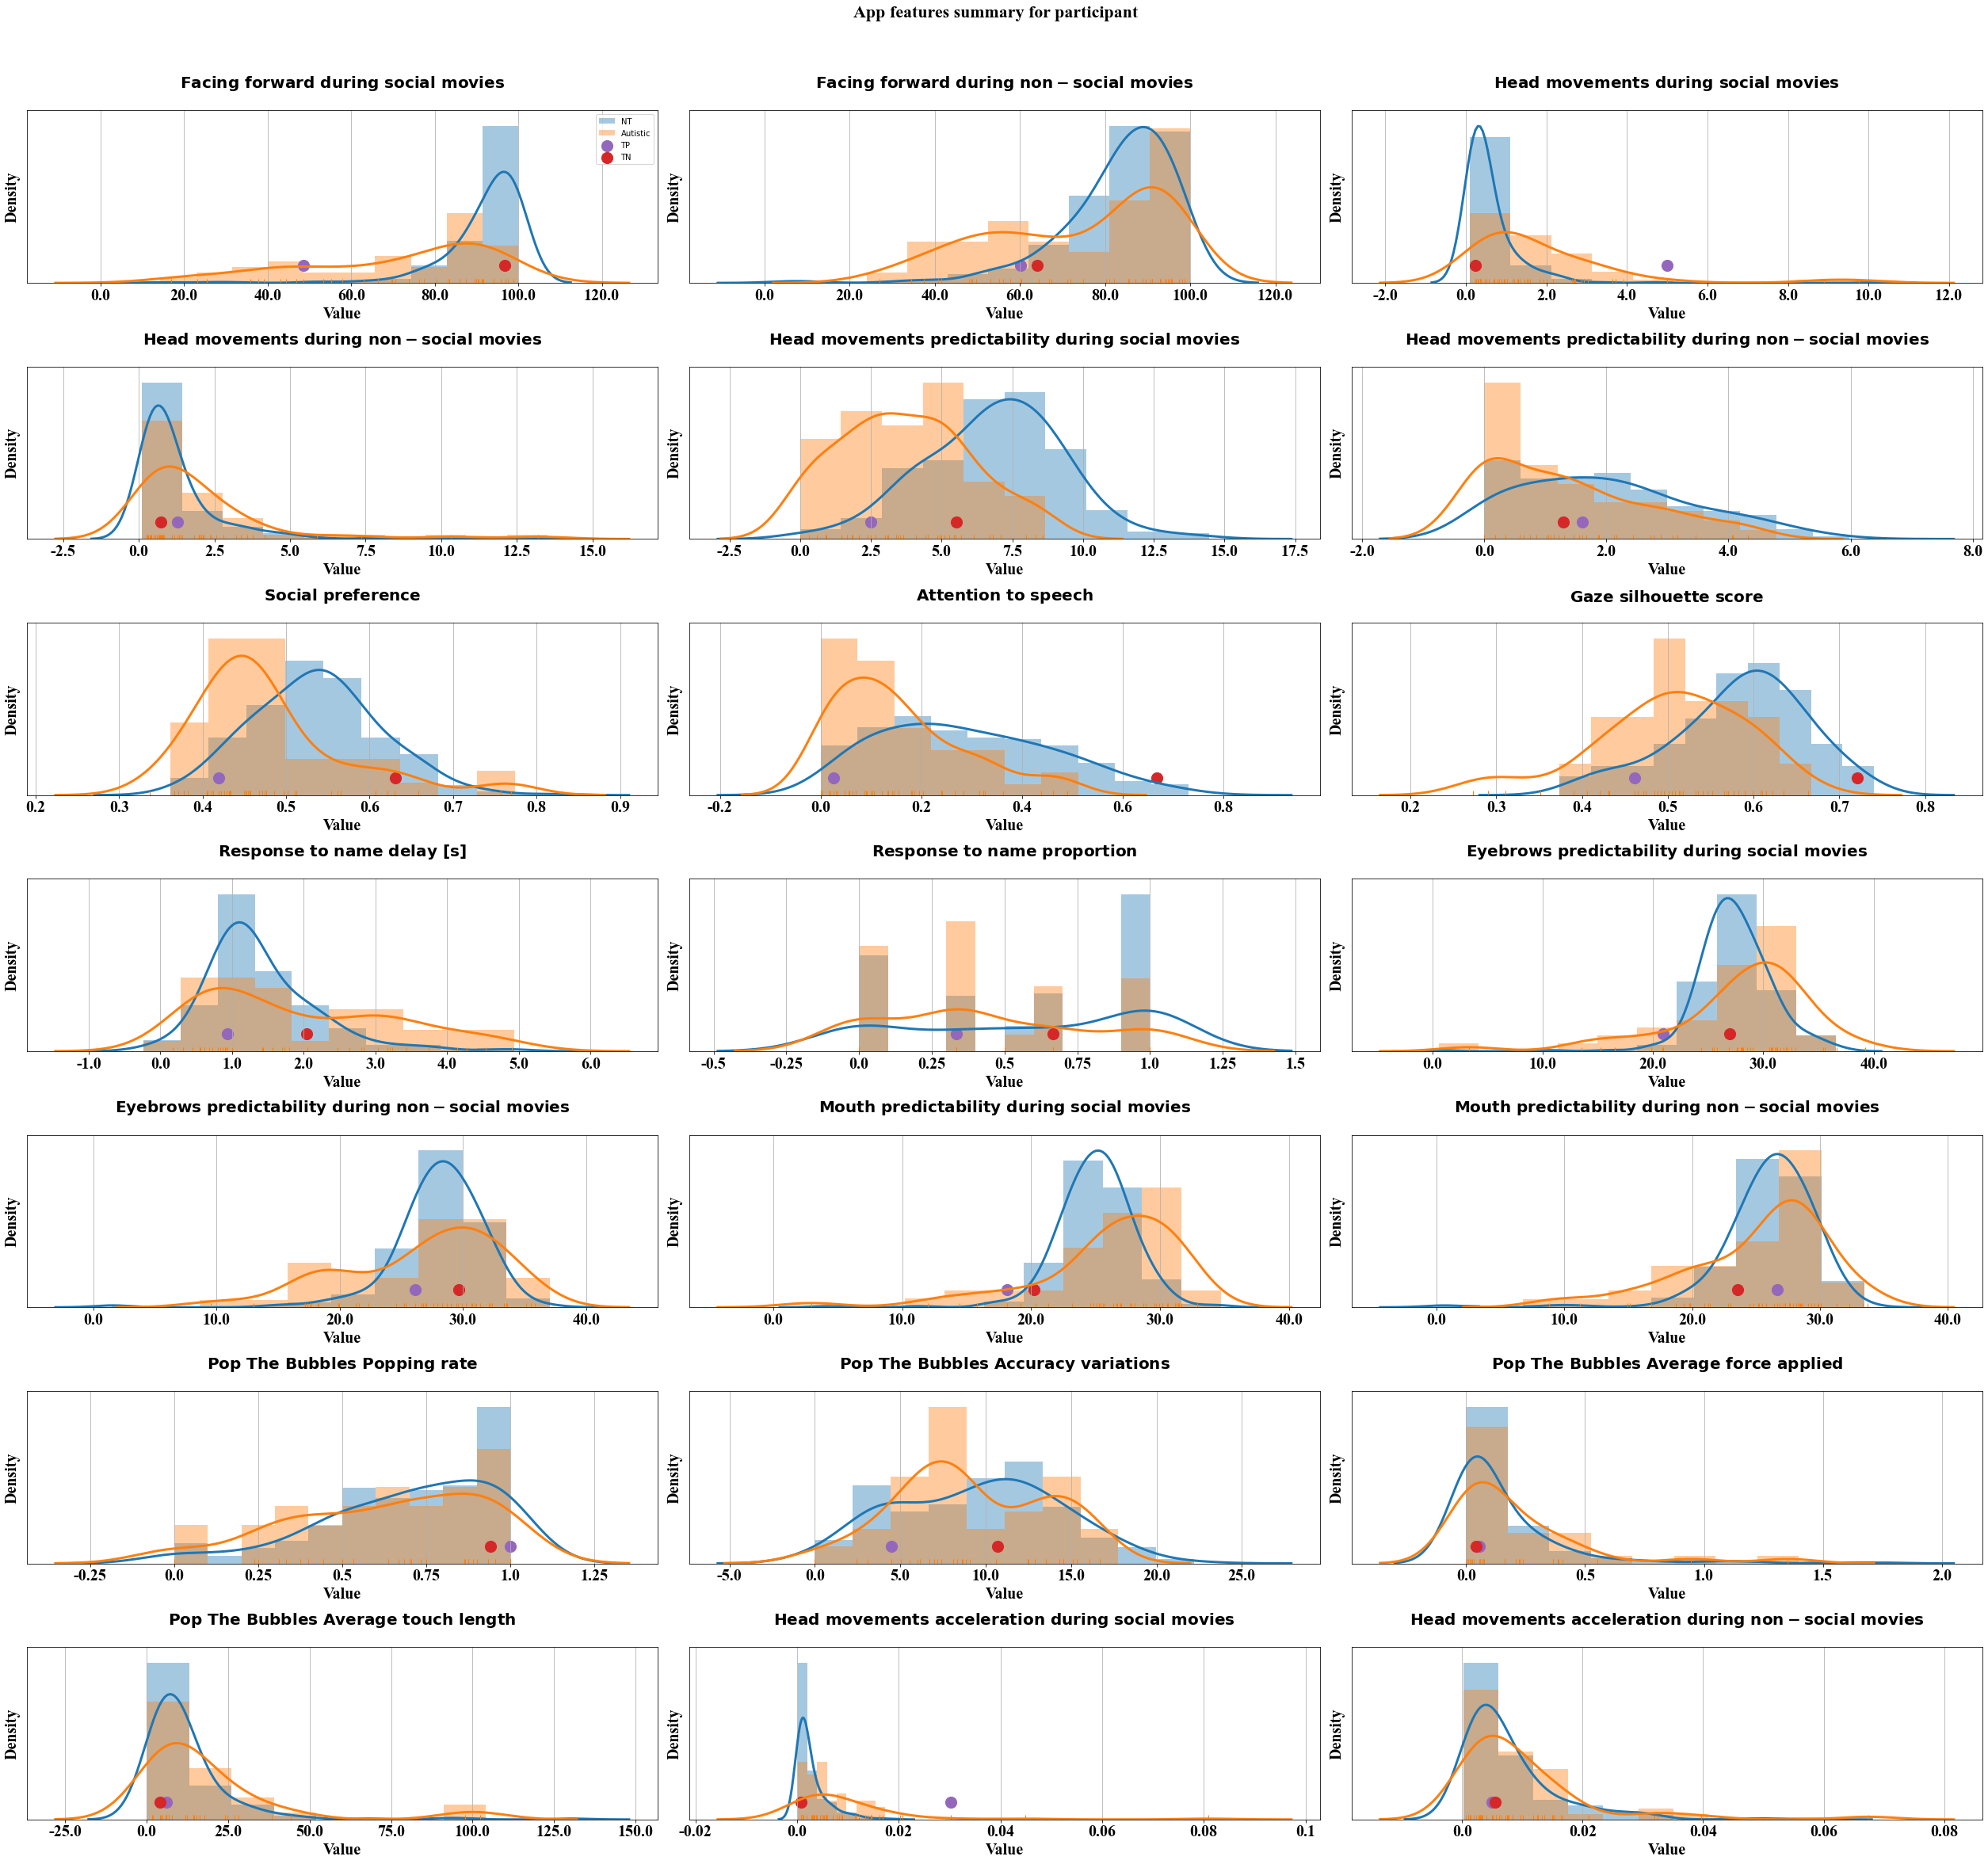

In [42]:
index_samples = [66, 165]


from utils import select
from matplotlib import rc
plt.rcParams["font.serif"] = "Times New Roman"

participant_id = exp.dataset.df.iloc[index_sample]['id']
age = exp.dataset.df.iloc[index_sample]['age']
sex = exp.dataset.df.iloc[index_sample]['sex']
diagnosis = exp.dataset.df.iloc[index_sample]['diagnosis']


n_plots = len(exp.features_name)
fig, axes = plt.subplots(n_plots//3, 3, figsize=(35, 32));axes = axes.flatten()
fig.suptitle("App features summary for participant", y=1.02, weight="bold", fontsize=22, **csfont)
for i, (feat, feature_name) in enumerate(feature_name_mapping.items()):

    title = r"$\bf{" + str(feature_name.replace(" ", "\ ")) + "}$\n"


    _, bins = np.histogram(select(exp.predictions_df, 'y_true', 0)[feat].dropna().to_numpy())
        
        
    sns.distplot(select(exp.predictions_df, 'y_true', 0)[feat].to_numpy(), bins=bins, label='NT',  color='tab:blue', ax=axes[i], kde_kws=dict(bw=0.4, lw=3))
    sns.distplot(select(exp.predictions_df, 'y_true', 1)[feat].to_numpy(), bins=bins, label='Autistic', rug=True,  color='tab:orange', ax=axes[i], kde_kws=dict(bw=0.4, lw=3))
    axes[i].set_title(title, fontsize=20, **csfont); axes[i].set_xlabel("Value", weight='bold', fontsize=20, **csfont)
    axes[i].set_yticks([]); axes[i].grid();y_min, y_max = axes[i].get_ylim(); axes[i].set_ylabel("Density", weight='bold', fontsize=20, **csfont)
    axes[i].set_xticks(axes[i].get_xticks(), np.round(axes[i].get_xticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)


    axes[i].scatter([exp.predictions_df.iloc[index_samples[0]][feat]], [0.1*(y_max-y_min)], s=200, color='#9467bd', label='TP')
    axes[i].scatter([exp.predictions_df.iloc[index_samples[1]][feat]], [0.1*(y_max-y_min)], s=200, color='#d62728', label='TN')
    
axes[0].legend()
plt.tight_layout()
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'participants_summary.png'), dpi=200, bbox_inches = 'tight')
plt.show()

In [ ]:
matrix_shap = averaged_shap_interactions_normalized[index_sample]*100
